In [1]:
import torch
import dgl.nn as dglnn
from dgl import from_networkx
from dgl import save_graphs, load_graphs
import torch.nn as nn
import torch as th
import torch.nn.functional as F
import dgl.function as fn
import networkx as nx
import pandas as pd
import socket
import struct
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import category_encoders as ce
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from collections import Counter
# from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import RandomUnderSampler
# from imblearn.pipeline import Pipeline
from sklearn.utils import class_weight
import timeit

from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import joblib
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


DGL backend not selected or invalid.  Assuming PyTorch for now.
DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)
Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


/scratch/kc01/na3038/my_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load NF-Bot IoT Dataset

In [2]:
# Load NF-Bot IoT Dataset
# data = pd.read_csv('/content/sample_data/NF-BoT-IoT.csv')
data = pd.read_csv('/scratch/kc01/na3038/NF-BoT-IoT-v2-sample.csv') #/scratch/kc01/na3038/NF-BoT-IoT-v2.csv

data['IPV4_SRC_ADDR'] = data.IPV4_SRC_ADDR.apply(lambda x: socket.inet_ntoa(struct.pack('>I', random.randint(0xac100001, 0xac1f0001))))
data['IPV4_SRC_ADDR'] = data.IPV4_SRC_ADDR.apply(str)
data['L4_SRC_PORT'] = data.L4_SRC_PORT.apply(str)
data['IPV4_DST_ADDR'] = data.IPV4_DST_ADDR.apply(str)
data['L4_DST_PORT'] = data.L4_DST_PORT.apply(str)
data['IPV4_SRC_ADDR'] = data['IPV4_SRC_ADDR'] + ':' + data['L4_SRC_PORT']
data['IPV4_DST_ADDR'] = data['IPV4_DST_ADDR'] + ':' + data['L4_DST_PORT']
data.drop(columns=['L4_SRC_PORT','L4_DST_PORT'],inplace=True)
data.drop(columns=['Label'],inplace = True)
data.rename(columns={"Attack": "label"},inplace = True)

le = LabelEncoder()
le.fit_transform(data.label.values)
data['label'] = le.transform(data['label'])
label = data.label


data.drop(columns=['label'],inplace = True)
scaler = StandardScaler()
data =  pd.concat([data, label], axis=1)

X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.3) # random_state=123

encoder = ce.TargetEncoder(cols=['TCP_FLAGS','L7_PROTO','PROTOCOL','ICMP_TYPE', 'ICMP_IPV4_TYPE','DNS_QUERY_TYPE','FTP_COMMAND_RET_CODE'])
encoder.fit(X_train, y_train)
X_train = encoder.transform(X_train)

cols_to_scale = list(set(list(X_train.iloc[:, 2:].columns ))  - set(list(['label','TCP_FLAGS','L7_PROTO','PROTOCOL','ICMP_TYPE', 'ICMP_IPV4_TYPE','DNS_QUERY_TYPE','FTP_COMMAND_RET_CODE'])) )
X_train[cols_to_scale] = scaler.fit_transform(X_train[cols_to_scale])

cols_to_norm = list(set(list(X_train.iloc[:, 2:].columns ))  - set(list(['label'])) )
X_train['h'] = X_train[ cols_to_norm ].values.tolist()

In [2]:
# joblib.dump(le, "/scratch/kc01/na3038/TrainedModels/bot-v2/label_encoder.pkl")
le = joblib.load("/scratch/kc01/na3038/TrainedModels/bot-v2/label_encoder.pkl")

In [3]:
X_test = encoder.transform(X_test)
X_test[cols_to_scale] = scaler.transform(X_test[cols_to_scale])
X_test['Edge_indx'] = list(range(len(X_test.values)))

X_test['h'] = X_test[ cols_to_norm ].values.tolist()

In [3]:
cols_to_norm =['OUT_PKTS',
 'DNS_TTL_ANSWER',
 'FTP_COMMAND_RET_CODE',
 'ICMP_TYPE',
 'DST_TO_SRC_SECOND_BYTES',
 'OUT_BYTES',
 'NUM_PKTS_128_TO_256_BYTES',
 'IN_BYTES',
 'NUM_PKTS_1024_TO_1514_BYTES',
 'MAX_IP_PKT_LEN',
 'TCP_FLAGS',
 'IN_PKTS',
 'NUM_PKTS_UP_TO_128_BYTES',
 'DNS_QUERY_TYPE',
 'DNS_QUERY_ID',
 'SRC_TO_DST_SECOND_BYTES',
 'RETRANSMITTED_OUT_PKTS',
 'MIN_TTL',
 'PROTOCOL',
 'DST_TO_SRC_AVG_THROUGHPUT',
 'MIN_IP_PKT_LEN',
 'NUM_PKTS_256_TO_512_BYTES',
 'RETRANSMITTED_IN_BYTES',
 'MAX_TTL',
 'DURATION_IN',
 'DURATION_OUT',
 'ICMP_IPV4_TYPE',
 'TCP_WIN_MAX_OUT',
 'FLOW_DURATION_MILLISECONDS',
 'SERVER_TCP_FLAGS',
 'NUM_PKTS_512_TO_1024_BYTES',
 'LONGEST_FLOW_PKT',
 'RETRANSMITTED_OUT_BYTES',
 'SHORTEST_FLOW_PKT',
 'TCP_WIN_MAX_IN',
 'L7_PROTO',
 'RETRANSMITTED_IN_PKTS',
 'CLIENT_TCP_FLAGS',
 'SRC_TO_DST_AVG_THROUGHPUT']
# =['DURATION_IN',
#  'RETRANSMITTED_OUT_BYTES',
#  'MAX_TTL',
#  'CLIENT_TCP_FLAGS',
#  'DNS_QUERY_TYPE',
#  'DNS_TTL_ANSWER',
#  'FTP_COMMAND_RET_CODE',
#  'OUT_BYTES',
#  'SRC_TO_DST_AVG_THROUGHPUT',
#  'LONGEST_FLOW_PKT',
#  'NUM_PKTS_128_TO_256_BYTES',
#  'DURATION_OUT',
#  'L7_PROTO',
#  'SERVER_TCP_FLAGS',
#  'FLOW_DURATION_MILLISECONDS',
#  'DNS_QUERY_ID',
#  'MAX_IP_PKT_LEN',
#  'SRC_TO_DST_SECOND_BYTES',
#  'RETRANSMITTED_IN_BYTES',
#  'IN_BYTES',
#  'NUM_PKTS_512_TO_1024_BYTES',
#  'ICMP_TYPE',
#  'PROTOCOL',
#  'TCP_WIN_MAX_OUT',
#  'MIN_IP_PKT_LEN',
#  'SHORTEST_FLOW_PKT',
#  'TCP_WIN_MAX_IN',
#  'OUT_PKTS',
#  'RETRANSMITTED_OUT_PKTS',
#  'NUM_PKTS_UP_TO_128_BYTES',
#  'IN_PKTS',
#  'RETRANSMITTED_IN_PKTS',
#  'DST_TO_SRC_AVG_THROUGHPUT',
#  'MIN_TTL',
#  'TCP_FLAGS',
#  'DST_TO_SRC_SECOND_BYTES',
#  'NUM_PKTS_256_TO_512_BYTES',
#  'ICMP_IPV4_TYPE',
#  'NUM_PKTS_1024_TO_1514_BYTES']

In [4]:
number_of_classes = 5

# Generate Graphs for train and test

In [4]:
G = nx.from_pandas_edgelist(X_train, "IPV4_SRC_ADDR", "IPV4_DST_ADDR", ['h','label'],create_using=nx.MultiGraph())
G = G.to_directed()
G = from_networkx(G,edge_attrs=['h','label'] )
G.ndata['h'] = th.ones(G.num_nodes(), G.edata['h'].shape[1])
G.edata['train_mask'] = th.ones(len(G.edata['h']), dtype=th.bool)
G.ndata['h'] = th.reshape(G.ndata['h'], (G.ndata['h'].shape[0], 1,G.ndata['h'].shape[1]))
G.edata['h'] = th.reshape(G.edata['h'], (G.edata['h'].shape[0], 1,G.edata['h'].shape[1]))
G = G.to('cuda')

In [7]:
file_path = "/scratch/kc01/na3038/TrainedModels/bot-v2/graph.dgl"
# save_graphs(file_path, G)

# Load the graph
loaded_graphs, _ = load_graphs(file_path)
G = loaded_graphs[0]

# Verify the loaded graph (optional)
print(G)
G = G.to('cuda')

Graph(num_nodes=963969, num_edges=1772750,
      ndata_schemes={'h': Scheme(shape=(1, 39), dtype=torch.float32)}
      edata_schemes={'train_mask': Scheme(shape=(), dtype=torch.uint8), 'label': Scheme(shape=(), dtype=torch.int64), 'h': Scheme(shape=(1, 39), dtype=torch.float32)})


In [26]:
G_test = nx.from_pandas_edgelist(X_test, "IPV4_SRC_ADDR", "IPV4_DST_ADDR", ['h','label','Edge_indx'],create_using=nx.MultiGraph())
G_test = G_test.to_directed()
G_test = from_networkx(G_test,edge_attrs=['h','label','Edge_indx'] )

actual = G_test.edata.pop('label')
G_test.ndata['feature'] = th.ones(G_test.num_nodes(), G.ndata['h'].shape[2])
G_test.ndata['feature'] = th.reshape(G_test.ndata['feature'], (G_test.ndata['feature'].shape[0], 1, G_test.ndata['feature'].shape[1]))
G_test.edata['h'] = th.reshape(G_test.edata['h'], (G_test.edata['h'].shape[0], 1, G_test.edata['h'].shape[1]))
G_test = G_test.to('cuda')

In [8]:
file_path = "/scratch/kc01/na3038/TrainedModels/bot-v2/graph_test.dgl"
# save_graphs(file_path, G_test)

# Load the graph
loaded_graphs, _ = load_graphs(file_path)
G_test = loaded_graphs[0]

# Verify the loaded graph (optional)
print(G_test)
G_test = G_test.to('cuda')

Graph(num_nodes=419017, num_edges=759752,
      ndata_schemes={'feature': Scheme(shape=(1, 39), dtype=torch.float32)}
      edata_schemes={'Edge_indx': Scheme(shape=(), dtype=torch.int64), 'h': Scheme(shape=(1, 39), dtype=torch.float32)})


In [14]:
file_path = "/scratch/kc01/na3038/TrainedModels/bot-v2/graph_test_labled.dgl"
# save_graphs(file_path, G_test)

# Load the graph
loaded_graphs, _ = load_graphs(file_path)
G_test = loaded_graphs[0]

# Verify the loaded graph (optional)
print(G_test)
G_test = G_test.to('cuda')

Graph(num_nodes=419017, num_edges=759752,
      ndata_schemes={'feature': Scheme(shape=(1, 39), dtype=torch.float32)}
      edata_schemes={'Edge_indx': Scheme(shape=(), dtype=torch.int64), 'label': Scheme(shape=(), dtype=torch.int64), 'h': Scheme(shape=(1, 39), dtype=torch.float32)})


In [28]:
file_path = "/scratch/kc01/na3038/TrainedModels/bot-v2/actual.npy"
np.save(file_path, actual)

# Load the graph
loaded_array = np.load(file_path, allow_pickle=True)
actual = th.from_numpy(loaded_array)
actual = le.inverse_transform(actual)
print(actual)

['DoS' 'DoS' 'DDoS' ... 'DDoS' 'DoS' 'DDoS']


In [29]:
np.unique(actual)

array(['Benign', 'DDoS', 'DoS', 'Reconnaissance', 'Theft'], dtype=object)

# Detection

In [44]:
def compute_accuracy(pred, labels):
    return (pred.argmax(1) == labels).float().mean().item()

class SAGELayer(nn.Module):
    def __init__(self, ndim_in, edims, ndim_out, activation):
        super(SAGELayer, self).__init__()
        ### force to outut fix dimensions
        self.W_msg = nn.Linear(ndim_in + edims, ndim_out)
        ### apply weight
        self.W_apply = nn.Linear(ndim_in + ndim_out, ndim_out)
        self.activation = activation

    def message_func(self, edges):
        return {'m': self.W_msg(th.cat([edges.src['h'], edges.data['h']], 2))}

    def forward(self, g_dgl, nfeats, efeats):
        with g_dgl.local_scope():
            g = g_dgl
            g.ndata['h'] = nfeats
            g.edata['h'] = efeats
            # Eq4
            g.update_all(self.message_func, fn.mean('m', 'h_neigh'))
            # Eq5
            g.ndata['h'] = F.relu(self.W_apply(th.cat([g.ndata['h'], g.ndata['h_neigh']], 2)))
            return g.ndata['h']


class SAGE(nn.Module):
    def __init__(self, ndim_in, ndim_out, edim, activation, dropout):
        super(SAGE, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(SAGELayer(ndim_in, edim, 128, activation))
        self.layers.append(SAGELayer(128, edim, ndim_out, activation))
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, g, nfeats, efeats):
        for i, layer in enumerate(self.layers):
            if i != 0:
                nfeats = self.dropout(nfeats)
            nfeats = layer(g, nfeats, efeats)
        return nfeats.sum(1)

class MLPPredictor(nn.Module):
    def __init__(self, in_features, out_classes):
        super().__init__()
        self.W = nn.Linear(in_features * 2, out_classes)

    def apply_edges(self, edges):
        h_u = edges.src['h']
        h_v = edges.dst['h']
        # global emb
        # emb = th.cat([h_u, h_v], 1)
        score = self.W(th.cat([h_u, h_v], 1))
        return {'score': score}

    def forward(self, graph, h):
        with graph.local_scope():
            graph.ndata['h'] = h
            graph.apply_edges(self.apply_edges)
            return graph.edata['score']

class Model(nn.Module):
    def __init__(self, ndim_in, ndim_out, edim, activation, dropout):
        super().__init__()
        self.gnn = SAGE(ndim_in, ndim_out, edim, activation, dropout)
        self.pred = MLPPredictor(ndim_out, 5)
    def forward(self, g, nfeats,efeats, edge_weight=None, feature_weight=None, embed=False):
      if edge_weight != None:
        #apply eweight one edges
        efe = []
        for i, x in enumerate(edge_weight):
          efe.append(list(th.Tensor.cpu(G.edata['h'][i][0]).detach().numpy()*th.Tensor.cpu(x).detach().numpy()))
        efe = th.FloatTensor(efe).cuda()
        efe = th.reshape(efe, (efe.shape[0], 1, efe.shape[1]))
        g.edata['h'] = efe = efe
      if feature_weight != None:
          efe= []
          weights = th.tensor(feature_weight,device='cuda')
          # weights = weights.view(1, 1, -1)
          g.edata['h'] *= weights
          efe = g.edata['h']
          g.edata['h'] = efe = efe
      h = self.gnn(g, nfeats,efeats)
      if embed:
        return h
      else:
        return self.pred(g, h)

Training acc: 0.9678956270217896
Training acc: 0.970066249370575
Training acc: 0.9693978428840637
Training acc: 0.9694440960884094
Training acc: 0.9695681929588318
Training acc: 0.9832175970077515
Training acc: 0.9704278707504272
Training acc: 0.9692675471305847
Training acc: 0.9690960049629211


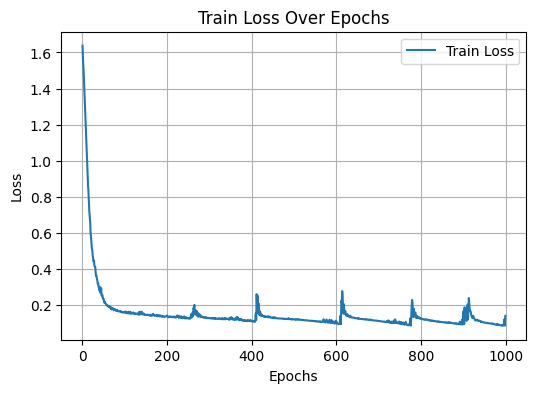

In [31]:
class_weights = class_weight.compute_class_weight(class_weight ='balanced',
                                                 classes= np.unique(G.edata['label'].cpu().numpy()),
                                                 y= G.edata['label'].cpu().numpy())
class_weights = th.FloatTensor(class_weights).cuda()
criterion = nn.CrossEntropyLoss(weight = class_weights)

nfeats = G.ndata['h']
efeats = G.edata['h']

edge_label = G.edata['label']
train_mask = G.edata['train_mask']

model = Model(G.ndata['h'].shape[2], 128, G.ndata['h'].shape[2], F.relu, 0.2).cuda()
opt = th.optim.Adam(model.parameters())

train_losses = []
for epoch in range(1,1000):
    pred = model(G, nfeats, efeats).cuda()
    loss = criterion(pred[train_mask] ,edge_label[train_mask])
    train_losses.append(loss)
    opt.zero_grad()
    loss.backward()
    opt.step()
    if epoch % 100 == 0:
      print('Training acc:', compute_accuracy(pred[train_mask], edge_label[train_mask]))

train_losses =  [tensor.cpu().detach().numpy() for tensor in train_losses]

epochs = range(1, 1000)
plt.figure(figsize=(6, 4))
plt.plot(epochs, train_losses, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

## Save Model

In [32]:
th.save(model, "/scratch/kc01/na3038/TrainedModels/bot-v2/model_state.pth")

In [45]:
def load_checkpoint(filepath):
  checkpoint = th.load(filepath, map_location='cuda')
  model = Model(G.ndata['h'].shape[2], 128, G.ndata['h'].shape[2], F.relu, 0.2)
  model.load_state_dict(checkpoint['state_dict'])
  return model

In [46]:
model = th.load("/scratch/kc01/na3038/TrainedModels/bot-v2/model_state.pth")
print(model)

Model(
  (gnn): SAGE(
    (layers): ModuleList(
      (0): SAGELayer(
        (W_msg): Linear(in_features=78, out_features=128, bias=True)
        (W_apply): Linear(in_features=167, out_features=128, bias=True)
      )
      (1): SAGELayer(
        (W_msg): Linear(in_features=167, out_features=128, bias=True)
        (W_apply): Linear(in_features=256, out_features=128, bias=True)
      )
    )
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (pred): MLPPredictor(
    (W): Linear(in_features=256, out_features=5, bias=True)
  )
)


In [47]:
model = model.to('cuda')

In [37]:
start_time = timeit.default_timer()
node_features_test = G_test.ndata['feature']
edge_features_test = G_test.edata['h']
test_pred = model(G_test, node_features_test, edge_features_test).cuda()
elapsed = timeit.default_timer() - start_time

print(str(elapsed) + ' seconds')

test_pred = test_pred.argmax(1)
test_pred = th.Tensor.cpu(test_pred).detach().numpy()

# actual = le.inverse_transform(actual)
test_pred = le.inverse_transform(test_pred)


# Calculate the precision, recall, F2-score, and support
report = classification_report(actual, test_pred, output_dict=True)

# Print a detailed report for each class
header = f"{'Class':<15}{'Precision':<10}{'Recall':<10}{'F2-score':<10}{'Accuracy':<10}{'Support':<10}"
print(header)
print("=" * len(header))

# Extract and print metrics for each class
for class_name, metrics in report.items():
    if class_name not in ['accuracy', 'macro avg', 'weighted avg']:
        accuracy = metrics['recall']  # For per-class, recall acts as accuracy
        print(f"{class_name:<15}{metrics['precision']:<10.4f}{metrics['recall']:<10.4f}{metrics['f1-score']:<10.4f}{accuracy:<10.4f}{int(metrics['support']):<10}")

# Print overall accuracy
print("\nOverall Accuracy:")
print(f"Accuracy: {report['accuracy']:.4f}")

# Print weighted averages
print("\nWeighted Averages:")
print(report['weighted avg'])

0.0066360002383589745 seconds
Class          Precision Recall    F2-score  Accuracy  Support   
Benign         0.9948    0.8333    0.9069    0.8333    81124     
DDoS           0.9941    0.9944    0.9942    0.9944    330036    
DoS            0.9863    0.9793    0.9828    0.9793    299908    
Reconnaissance 0.7156    0.9428    0.8137    0.9428    47218     
Theft          0.8735    0.9939    0.9298    0.9939    1466      

Overall Accuracy:
Accuracy: 0.9680

Weighted Averages:
{'precision': 0.9735523428648185, 'recall': 0.968035622150386, 'f1-score': 0.9690525271553146, 'support': 759752.0}


In [ ]:
# Without random mapping
# 0.06323996299761347 seconds
# Class          Precision Recall    F2-score  Accuracy  Support   
# =================================================================
# Benign         0.8537    0.5015    0.6318    0.5015    81148     
# DDoS           0.5591    0.9208    0.6958    0.9208    330274    
# DoS            0.8253    0.3832    0.5234    0.3832    299674    
# Reconnaissance 0.9612    0.5602    0.7079    0.5602    47204     
# Theft          0.9610    0.9835    0.9721    0.9835    1452      

# Overall Accuracy:
# Accuracy: 0.6417

# Weighted Averages:
# {'precision': 0.7213357138164559, 'recall': 0.6417172972233044, 'f1-score': 0.6222497187724996, 'support': 759752.0}

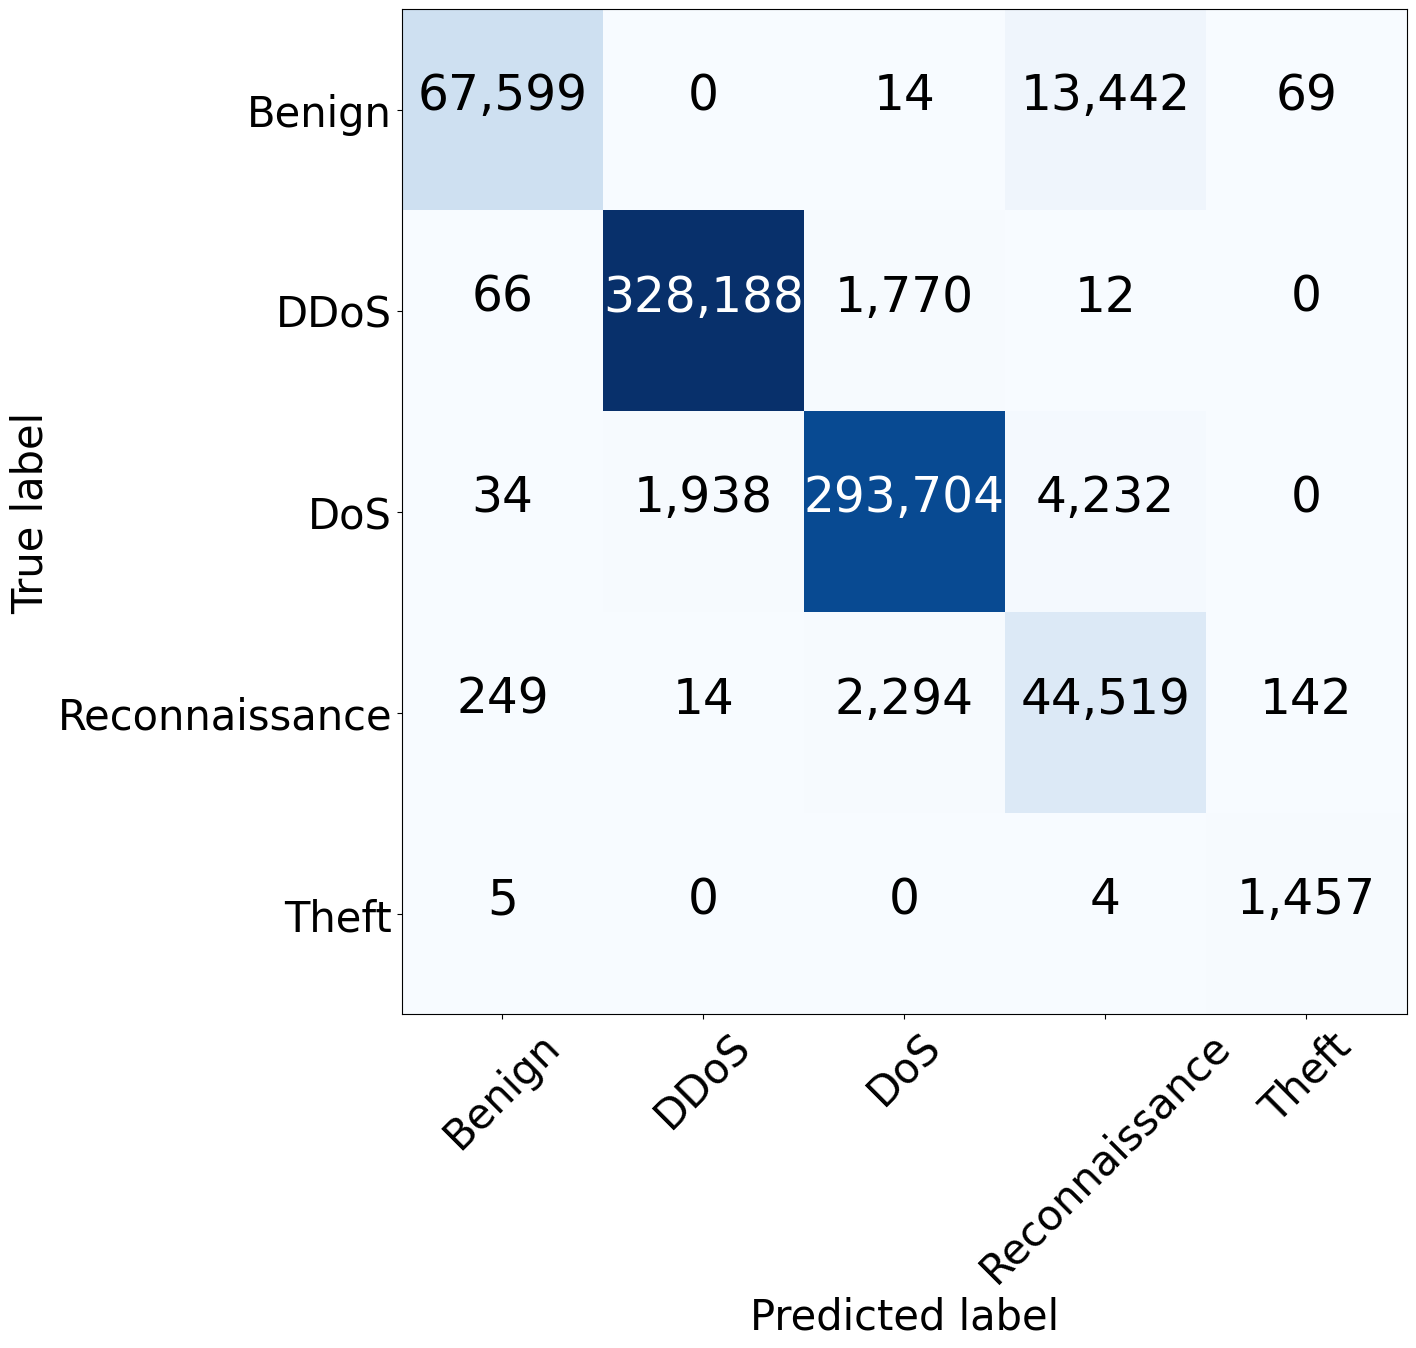

In [38]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm,
                          target_names,
                          # title='Confusion matrix',
                          cmap=None,
                          normalize=True,
                          fontsize=30,
                          text_fontsize=35):

    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(12, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    # plt.title(title,fontsize=fontsize + 2)
    # plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45,fontsize=fontsize)
        plt.yticks(tick_marks, target_names,fontsize=fontsize)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     fontsize=text_fontsize,
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     fontsize=text_fontsize,
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label',fontsize=fontsize)
    plt.xlabel('Predicted label',fontsize=fontsize)
    plt.subplots_adjust(left=0.15, bottom=0.15)
    plt.show()
plot_confusion_matrix(cm = confusion_matrix(actual, test_pred),
                      normalize    = False,
                      target_names = np.unique(actual),
                      # title        = "Confusion Matrix"
                      )

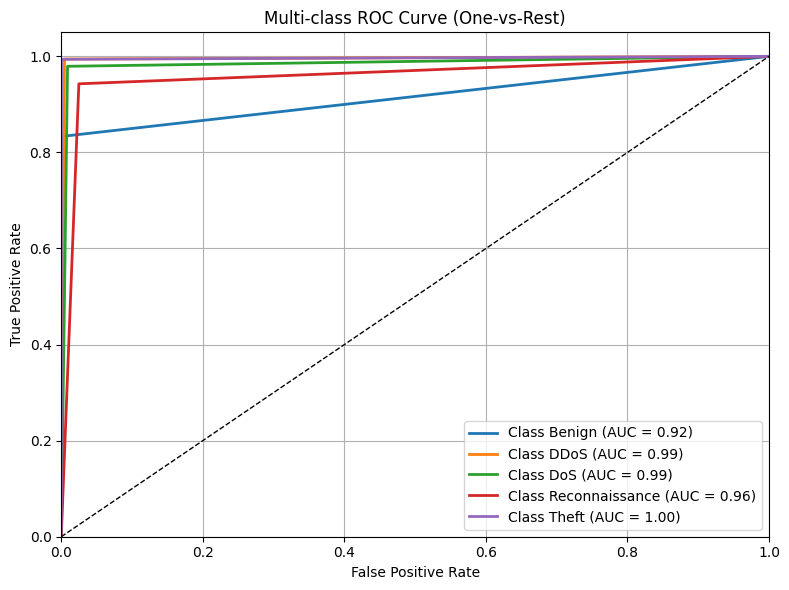

In [39]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Load example dataset
X = actual
y = test_pred
classes = np.unique(actual)
n_classes = len(classes)

X_bin = label_binarize(X, classes=classes)  # shape: (n_samples, n_classes)
y_bin = label_binarize(y, classes=classes)  # shape: (n_samples, n_classes)

# 2. Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(X_bin[:, i], y_bin[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"Class {classes[i]} (AUC = {roc_auc:.2f})")

# 3. Add plot decorations
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve (One-vs-Rest)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
## Save TPs for use in XAI

In [40]:
true_positives = {}
for i in range(len(actual)):
    if test_pred[i] == actual[i]:
      # key = G_test.edata['label'][i].cpu().item()
      key = actual[i]
      if key not in true_positives:
          true_positives[key] = []
      true_positives[key].append(G_test.edata['Edge_indx'][i].cpu().item())

In [51]:
import pickle

file_path = '/scratch/kc01/na3038/TrainedModels/bot-v2/true_positives_sample.pkl'

# with open(file_path, 'wb') as f:
#     pickle.dump(true_positives, f)
# print(f"True positives saved to {file_path}")

In [52]:
with open(file_path, 'rb') as f:
    true_positives = pickle.load(f)

# true_positives

# E-PGExplainer

In [43]:
import torch
from math import sqrt
import math
from tqdm import tqdm
from dgl import EID,NID,khop_out_subgraph, khop_in_subgraph, batch
from torch.optim import Adam

import torch.nn as nn

In [56]:
class ExplainerModel(nn.Module):
    def __init__(self):
        super(ExplainerModel, self).__init__()
        self.elayers = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 39)
        )

    def forward(self, x):
        x = self.elayers(x)
        x = x.mean(dim=0)
        return x

In [48]:
def generate_computation_graph(graph,edge_id):
    # Extract source node-centered k-hop subgraph from the edge_id and its associated node and edge features.
    num_hops = 2
    source_node = th.Tensor.cpu(graph.edges()[0][edge_id]).detach().numpy()
    dest_node = th.Tensor.cpu(graph.edges()[1][edge_id]).detach().numpy()
    edge_h = graph.edata['h'][edge_id]
    sg, inverse_indices = khop_in_subgraph(graph, source_node, num_hops)

    return sg,inverse_indices

def create_explainer_input(pair, embeds):
        rows = pair[0]
        cols = pair[1]
        row_embeds = embeds[rows]
        col_embeds = embeds[cols]
        input_expl = th.cat([row_embeds, col_embeds], 1)
        return input_expl

In [53]:
#Updated Version
class PGExplainer(nn.Module):
    def __init__(self,model,num_hops=None,explain_graph=True,coff_budget=0.01, coff_connect=5e-4,sample_bias=0.0,):
      super(PGExplainer, self).__init__()
      self.elayers  = ExplainerModel()
      self.model = model
      self.graph_explanation = explain_graph
      self.num_hops = num_hops

      # training hyperparameters for PGExplainer
      self.coff_budget = coff_budget
      self.coff_connect = coff_connect
      self.sample_bias = sample_bias
      self.init_bias = 0.0

    def set_masks(self, graph, edge_mask=None):
        if edge_mask is None:
            num_nodes = graph.num_nodes()
            num_edges = graph.num_edges()

            init_bias = self.init_bias
            std = nn.init.calculate_gain("relu") * math.sqrt(
                2.0 / (2 * num_nodes)
            )
            self.edge_mask = torch.randn(num_edges) * std + init_bias
        else:
            self.edge_mask = edge_mask

        self.edge_mask = self.edge_mask.to(graph.device)

    def clear_masks(self):
        self.edge_mask = None
    def concrete_sample(self, w, beta=1.0, training=True):
          if training:
              bias = self.sample_bias
              random_noise = torch.rand(w.size()).to(w.device)
              random_noise = bias + (1 - 2 * bias) * random_noise
              gate_inputs = torch.log(random_noise) - torch.log(
                  1.0 - random_noise
              )
              gate_inputs = (gate_inputs + w) / beta
              gate_inputs = torch.sigmoid(gate_inputs)
          else:
              gate_inputs = torch.sigmoid(w)

          return gate_inputs

    def loss(self, prob, ori_pred):
        target_prob = prob.gather(-1, ori_pred.unsqueeze(-1))
        # 1e-6 added to prob to avoid taking the logarithm of zero
        target_prob += 1e-6
        # computing the log likelihood for a single prediction
        pred_loss = torch.mean(-torch.log(target_prob))

        # size
        edge_mask = self.sparse_mask_values
        if self.coff_budget <= 0:
            size_loss = self.coff_budget * torch.sum(edge_mask)
        else:
            size_loss = self.coff_budget * F.relu(
                torch.sum(edge_mask) - self.coff_budget
            )

        # entropy
        scale = 0.99
        edge_mask = self.edge_mask * (2 * scale - 1.0) + (1.0 - scale)
        mask_ent = -edge_mask * torch.log(edge_mask) - (
            1 - edge_mask
        ) * torch.log(1 - edge_mask)
        mask_ent_loss = self.coff_connect * torch.mean(mask_ent)

        loss = pred_loss + size_loss + mask_ent_loss
        return loss

    def train_step_node(self, edges, graph, temperature, **kwargs):
          self.model = self.model.to(graph.device)
          self.elayers = self.elayers.to(graph.device)

          if isinstance(edges, torch.Tensor):
              edges = edges.tolist()
          if isinstance(edges, int):
              edges = [edges]

          prob, _, batched_graph, inverse_indices = self.explain_node(
              edges, graph, temperature, training=True, **kwargs
          )

          pred = self.model(
              batched_graph, self.batched_feats,self.batched_efeats, **kwargs
          )
          pred = pred.argmax(-1).data

          loss = self.loss(prob[inverse_indices], pred[inverse_indices])

          del batched_graph,_, inverse_indices,prob, pred

          torch.cuda.empty_cache()

          return loss

    def explain_node(self, edges, graph, temperature=1.0, training=False, **kwargs):
          if isinstance(edges, torch.Tensor):
              edges = edges.tolist()
          if isinstance(edges, int):
              edges = [edges]

          self.model = self.model.to(graph.device)
          self.elayers = self.elayers.to(graph.device)

          if training:
              self.elayers.train()
          else:
              self.elayers.eval()

          self.model.eval()

          batched_graph = []
          batched_embed = []
          for edge_id in edges:
              sg, inverse_indices =  generate_computation_graph(graph, edge_id)
              sg.ndata["feat"]= features[sg.ndata[NID].long()]
              sg.edata["feat"]= edge_features[sg.edata[EID].long()]
              # feats = features[sg.ndata[NID].long()]
              # efeats = edge_features[sg.edata[EID].long()]
              sg.edata["train"] = torch.tensor(
                [eid in inverse_indices for eid in sg.edges(form='eid')], device=sg.device
              )

              embed = self.model(sg, sg.ndata["feat"],sg.edata["feat"],embed=True)
              embed = embed.data

              # col, row = sg.edges()
              # col_emb = embed[col.long()]
              # row_emb = embed[row.long()]
              # self_emb = embed[inverse_indices[0]].repeat(sg.num_edges(), 1)
              # need to concat these if considering combine node-based edge embeddings with raw edge features
              emb = create_explainer_input(sg.edges(), embed) # i think not needed because we do not consider on node embeddings
              batched_embed.append(emb)
              batched_graph.append(sg)
              # print("train step edge:",edge_id)

          batched_graph = batch(batched_graph)

          batched_embed = torch.cat(batched_embed)
          batched_embed = self.elayers(batched_embed) #1,8
          values = batched_embed.reshape(-1) # 8
          values = self.concrete_sample(
              values, beta=temperature, training=training
          )
          self.sparse_mask_values = values

          # col, row = batched_graph.edges()
          # reverse_eids = batched_graph.edge_ids(row, col).long()
          # edge_mask = (values + values[reverse_eids]) / 2
          # todo
          edge_mask = values

          self.set_masks(batched_graph, edge_mask)

          batched_feats = batched_graph.ndata['feat']
          batched_efeats = batched_graph.edata['h']
          # the model prediction with the updated edge mask
          logits = self.model(
              batched_graph, batched_feats, batched_efeats, feature_weight=self.edge_mask, **kwargs
          )
          probs = F.softmax(logits, dim=-1)
          # print(probs.shape)

          batched_inverse_indices = (
              batched_graph.edata["train"].nonzero().squeeze(1)
          )

          if training:
              self.batched_feats = batched_feats
              self.batched_efeats = batched_efeats
              probs = probs.data
          else:
              self.clear_masks()

          del batched_feats, batched_efeats, logits
          torch.cuda.empty_cache()
          return (
              probs,
              edge_mask,
              batched_graph,
              batched_inverse_indices,
          )

In [51]:
features = G_test.ndata['feature']
edge_features = G_test.edata['h']
labels = G_test.edata['label']

In [58]:
final_features ={key: [] for key in range(5)}
for attack in true_positives.keys():
    print ("----------", attack,"----------")
    attack_id = le.transform([attack])[0]
    class_indices = torch.nonzero(labels == attack_id, as_tuple=False).squeeze()
    selected_indices = class_indices[torch.randperm(class_indices.size(0))][:10] # select 50 random edges from train data for each attack

    ### train the explainer for each attack:
    explainer = PGExplainer(
        model, num_hops=2, explain_graph=False, coff_budget=0.01, coff_connect=5e-4
    )
    explainer = explainer.to('cuda')

    torch.cuda.empty_cache()
    init_tmp, final_tmp = 5.0, 1.0
    optimizer_exp = torch.optim.Adam(explainer.parameters(), lr=0.01) #, weight_decay=0.001
    epochs = 5
    train_losses = []
    for epoch in range(epochs):
        tmp = float(init_tmp * np.power(final_tmp / init_tmp, epoch / epochs))
        loss = explainer.train_step_node(selected_indices, G_test, tmp)#G.edges(form='eid')
        train_losses.append(loss.item())
        optimizer_exp.zero_grad()
        loss.backward()
        optimizer_exp.step()
    print(loss.item())

    #explain with trained model
    edges_to_explain = random.sample(true_positives[attack],10)
    probs, edge_weight, bg, inverse_indices = explainer.explain_node(edges_to_explain, G_test)
    edge_weight = edge_weight.cpu().detach().numpy()


    feature_importance = {}
    for k in range(39):
      feature_importance[cols_to_norm[k]]=edge_weight[k]

    sorted_items = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)#[:20]
    for key, value in sorted_items:
      # print(f'{key}: {value}') #display importance scores
      final_features[attack_id].append(cols_to_norm.index(key))

    del explainer, train_losses, probs, edge_weight, bg, inverse_indices, feature_importance, sorted_items
    torch.cuda.empty_cache()
    print('========================================================')
print(final_features)

---------- DoS ----------
0.026381267234683037
---------- DDoS ----------
0.026396162807941437
---------- Benign ----------
0.026439150795340538
---------- Reconnaissance ----------
0.049632299691438675
---------- Theft ----------
0.027623437345027924
{0: [32, 38, 30, 20, 2, 18, 5, 13, 29, 3, 15, 4, 19, 17, 6, 9, 34, 31, 22, 25, 24, 27, 26, 35, 0, 14, 11, 33, 10, 16, 7, 23, 36, 21, 12, 37, 8, 28, 1], 1: [15, 27, 10, 33, 29, 3, 5, 8, 6, 13, 28, 24, 23, 16, 11, 18, 37, 25, 20, 35, 7, 38, 14, 21, 31, 9, 1, 17, 26, 19, 0, 32, 2, 12, 34, 22, 30, 36, 4], 2: [26, 0, 10, 7, 19, 30, 38, 5, 34, 18, 36, 2, 31, 11, 33, 17, 27, 23, 22, 25, 9, 4, 29, 13, 12, 28, 14, 37, 32, 1, 3, 15, 20, 35, 8, 6, 16, 24, 21], 3: [7, 0, 5, 34, 33, 22, 17, 9, 4, 13, 2, 30, 8, 12, 10, 18, 23, 36, 29, 32, 24, 38, 27, 28, 3, 16, 20, 35, 6, 26, 19, 25, 1, 11, 14, 37, 21, 15, 31], 4: [26, 36, 37, 19, 12, 8, 30, 10, 31, 0, 11, 5, 23, 3, 4, 18, 29, 24, 21, 9, 17, 25, 20, 14, 1, 38, 28, 33, 16, 15, 35, 7, 6, 22, 27, 32, 13, 

In [ ]:
# ---------- DDoS ----------
# /jobfs/144456350.gadi-pbs/ipykernel_206335/3038387700.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
#   weights = th.tensor(feature_weight,device='cuda')
# 0.3338977098464966
# ========================================================
# ---------- Benign ----------
# /jobfs/144456350.gadi-pbs/ipykernel_206335/3038387700.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
#   weights = th.tensor(feature_weight,device='cuda')
# 0.3219018876552582
# ========================================================
# ---------- DoS ----------
# /jobfs/144456350.gadi-pbs/ipykernel_206335/3038387700.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
#   weights = th.tensor(feature_weight,device='cuda')
# 0.2362789809703827
# ========================================================
# ---------- Reconnaissance ----------
# /jobfs/144456350.gadi-pbs/ipykernel_206335/3038387700.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
#   weights = th.tensor(feature_weight,device='cuda')
# 0.7374891042709351
# ========================================================
# ---------- Theft ----------
# /jobfs/144456350.gadi-pbs/ipykernel_206335/3038387700.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
#   weights = th.tensor(feature_weight,device='cuda')
# 0.321537047624588
# ========================================================
# {0: [9, 5, 24, 16, 14, 3, 37, 33, 21, 1, 13, 35, 26, 4, 0, 23, 28, 17, 38, 11, 22, 32, 19, 31, 7, 30, 29, 2, 10, 36, 8, 25, 6, 34, 15, 20, 18, 12, 27], 1: [26, 32, 14, 0, 20, 5, 22, 8, 34, 36, 10, 25, 1, 2, 13, 24, 6, 16, 23, 18, 33, 31, 9, 12, 3, 7, 29, 27, 37, 4, 38, 28, 15, 30, 35, 11, 21, 17, 19], 2: [13, 0, 9, 17, 38, 14, 2, 25, 35, 36, 1, 20, 5, 37, 31, 3, 10, 32, 11, 12, 8, 6, 4, 18, 7, 30, 22, 15, 19, 16, 23, 33, 34, 26, 24, 28, 27, 29, 21], 3: [38, 25, 18, 2, 12, 3, 14, 29, 1, 37, 21, 6, 5, 26, 30, 34, 36, 15, 31, 33, 32, 10, 8, 7, 22, 24, 23, 27, 28, 20, 9, 0, 19, 16, 13, 11, 4, 35, 17], 4: [38, 18, 31, 3, 8, 23, 36, 27, 4, 16, 6, 17, 29, 28, 5, 11, 21, 7, 19, 24, 37, 15, 30, 35, 2, 10, 20, 22, 34, 26, 14, 33, 12, 25, 1, 13, 9, 32, 0]}

Codes for Single class Explain

In [ ]:
selected_indices = []

for class_label in range(0,1):
    class_indices = torch.nonzero(labels == class_label, as_tuple=False).squeeze()[:10]
    selected_indices.extend(class_indices)
len(selected_indices)

10

In [ ]:
# torch.cuda.empty_cache()
explainer = PGExplainer(
        model, num_hops=2, explain_graph=False, coff_budget=0.01, coff_connect=5e-4
    )
explainer = explainer.to('cuda')

init_tmp, final_tmp = 5.0, 1.0
optimizer_exp = torch.optim.Adam(explainer.parameters(), lr=0.01) #, weight_decay=0.001
epochs = 5
train_losses = []
for epoch in range(epochs):
    # selected_indices = torch.randperm(G.edges(form='eid').size(0), device='cuda:0')[:10]  # Get random indices
    # random_edges = G.edges(form='eid')[selected_indices]  # Use the indices to select from the tensor

    tmp = float(init_tmp * np.power(final_tmp / init_tmp, epoch / epochs))
    loss = explainer.train_step_node(selected_indices, G_test, tmp)#G.edges(form='eid')
    train_losses.append(loss.item())
    optimizer_exp.zero_grad()
    loss.backward()
    optimizer_exp.step()
    print(epoch, loss)

/tmp/ipython-input-8-1277807201.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weights = th.tensor(feature_weight,device='cuda')


0 tensor(0.2229, device='cuda:0', grad_fn=<AddBackward0>)
1 tensor(0.3095, device='cuda:0', grad_fn=<AddBackward0>)
2 tensor(0.1731, device='cuda:0', grad_fn=<AddBackward0>)
3 tensor(0.0581, device='cuda:0', grad_fn=<AddBackward0>)
4 tensor(0.0512, device='cuda:0', grad_fn=<AddBackward0>)


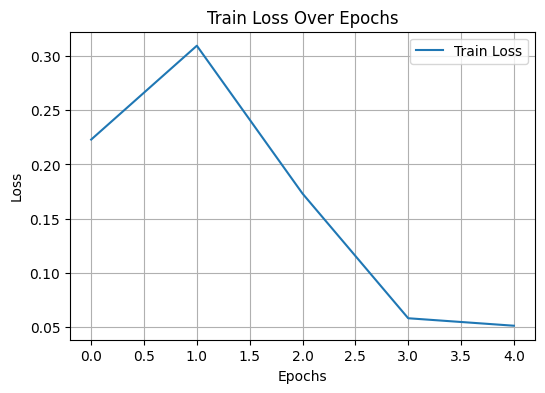

In [ ]:
epochs = range(0, len(train_losses))
plt.figure(figsize=(6, 4))
plt.plot(epochs, train_losses, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()
# 10 edges, 10 epoches

In [ ]:
le.transform(['Benign'])

array([0])

In [ ]:
edges_to_explain = random.sample(true_positives['Benign'],10)
probs, edge_weight, bg, inverse_indices = explainer.explain_node(edges_to_explain, G_test)
edge_weight = edge_weight.cpu().detach().numpy()

feature_importance = {}
for k in range(8):
  feature_importance[cols_to_norm[k]]=edge_weight[k]
sorted_items = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
for key, value in sorted_items:
  print(f'{key}: {value}') #display importance scores

IN_BYTES: 1.6484761999890907e-07
TCP_FLAGS: 8.109129367994683e-08
L7_PROTO: 4.834532418840354e-08
FLOW_DURATION_MILLISECONDS: 3.0628456215708866e-08
OUT_PKTS: 8.550905761239846e-09
PROTOCOL: 1.6526775503677982e-09
OUT_BYTES: 1.1996191817686963e-09
IN_PKTS: 8.994483630120342e-11


/tmp/ipython-input-8-1277807201.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  weights = th.tensor(feature_weight,device='cuda')


# E-GNNExplainer

In [48]:
from math import sqrt
from tqdm import tqdm
from dgl import EID,NID,khop_out_subgraph, khop_in_subgraph
import dgl
from sklearn.utils import class_weight
import torch.nn as nn
from torch.cuda.amp import autocast, GradScaler
from torch.optim.lr_scheduler import OneCycleLR
from scipy.stats import linregress

linear_threshold = 0.001  # Threshold for the slope to be considered "linear"
lookback_epochs = 200  # Number of epochs to check for linearity

def init_efeat_masks(graph, efeat):
    efeat_size = efeat.size()[2]
    num_edges = graph.num_edges()
    num_nodes = graph.num_nodes()
    device = efeat.device
    std = 0.1
    # feat_mask = [[f1, f2, .... fn]] / n = nb_features
    efeat_mask = nn.Parameter(th.randn(1, efeat_size, device=device) * std)
    std = nn.init.calculate_gain("relu") * sqrt(2.0 / (2 * num_edges))
    return efeat_mask


# Regularization loss
def loss_regularize_efeat(loss, feat_mask):
    eps = 1e-15
    alpha1 = 0.005,
    alpha2 = 1.0
    beta1 = 1.0
    beta2 = 0.1

    feat_mask = feat_mask.sigmoid()
    loss = loss + beta1 * th.mean(feat_mask)
    ent = -feat_mask * th.log(feat_mask + eps) - (
        1 - feat_mask
    ) * th.log(1 - feat_mask + eps)
    loss = loss + beta2 * ent.mean()
    return loss



# Edge mask
def explain_edge_features(model, edge_id, graph, node_feat, edge_feat, **kwargs):
    model = model.to(graph.device)
    model.eval()

    num_hops = 2
    source_node = th.Tensor.cpu(graph.edges()[0][edge_id]).detach().numpy()
    dest_node = th.Tensor.cpu(graph.edges()[1][edge_id]).detach().numpy()
    edge_h = graph.edata['h'][edge_id]
    sg, inverse_indices = khop_in_subgraph(graph, source_node, num_hops)

    sg = dgl.add_edges(sg, inverse_indices.item(), dest_node)
    # So we can add its features in last position
    sg.edata['Edge_indx'][-1] = graph.edata['Edge_indx'][edge_id]
    sg.edata['label'][-1] = graph.edata['label'][edge_id]
    sg.edata['h'][-1][0] = graph.edata['h'][edge_id]

    # edge_indice using Edge_indx
    for indx, edge_indx in enumerate(sg.edata["Edge_indx"]):
        if (edge_indx == graph.edata["Edge_indx"][edge_id]).all() :
                edge_indice = indx
                break

    # EID = NID = _ID
    # tensor([0, 1, 2, 4]) : nodes and edges ids
    sg_edges = sg.edata[EID].long()
    sg_nodes = sg.ndata[NID].long()

    edge_feat = edge_feat[sg_edges]
    node_feat = node_feat[sg_nodes]

    edge_label_1 = sg.edata["label"][edge_indice]

    # edge_mask
    efeat_mask = init_efeat_masks(sg, edge_feat)
    params = [efeat_mask]
    optimizer = th.optim.Adam(params, lr = 0.01)
    scheduler = OneCycleLR(optimizer, max_lr=0.01, steps_per_epoch=1, epochs=250)

    criterion2 = nn.CrossEntropyLoss()
    # criterion2 = nn.BCEWithLogitsLoss()
    train_mask2 = th.ones(len(sg.edata['h']), dtype=th.bool)
    import datetime

    xai_train_losses = []
    scaler = GradScaler()
    for epoch in range(1, 250):
        optimizer.zero_grad()
        # Apply edge feature mask
        h = edge_feat * efeat_mask.sigmoid()
        # Edge mask
        logits = model(g = sg, nfeats = node_feat, efeats = h,**kwargs).cuda()
        # predicted_classes= logits[:, edge_label_1, :].squeeze()
        # predicted_classes = th.argmax(logits, dim=1).squeeze()
        loss = criterion2(logits[edge_indice], edge_label_1)
        # loss = loss_regularize(loss11, edge_mask)
        xai_train_losses.append(loss.item())
        # loss.backward()
        # optimizer.step()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        if epoch >= lookback_epochs:
          # Calculate the slope of the recent `lookback_epochs` losses
          recent_losses = xai_train_losses[-lookback_epochs:]
          epochs_range = np.arange(lookback_epochs)
          slope, _, _, _, _ = linregress(epochs_range, recent_losses)

          # Check if the slope is below the threshold for linearity
          if abs(slope) < linear_threshold:
              # print(f"Stopping early at epoch {epoch} due to linear loss with slope {slope:.5f}")
              break

        del logits #, predicted_classes
        th.cuda.empty_cache()


    # epochs = range(0, len(xai_train_losses))
    # plt.figure(figsize=(6, 4))
    # # xai_train_losses =  [tensor.cpu().detach().numpy() for tensor in xai_train_losses]
    # plt.plot(epochs, xai_train_losses, label='Train Loss')
    # plt.xlabel('Epochs')
    # plt.ylabel('Loss')
    # plt.show()
    # efeat_mask = efeat_mask.detach().sigmoid().squeeze()
    del xai_train_losses, epochs_range, slope
    th.cuda.empty_cache()
    return edge_indice, sg, efeat_mask, loss.item()

In [49]:
nfeats = G_test.ndata['feature']
efeats = G_test.edata['h']
labels = G_test.edata['label']
final_feature_weights ={key: [] for key in range(5)}

In [53]:
nfeats = G_test.ndata['feature']
efeats = G_test.edata['h']
final_features ={key: [] for key in range(5)}

for i in range(0,5):
  attk_class = le.inverse_transform([i])[0]
  print('Class type explaining:', attk_class)
  attack_edge_to_explain = 0 #initialize
  attack_feature_array = {}
  true_predicted_edge_indexes = random.sample(true_positives[attk_class], 10) #50
  for edge_index in true_predicted_edge_indexes:
      attack_indices_list = (G_test.edata['Edge_indx'] == edge_index).nonzero(as_tuple=True)[0].to("cuda").tolist()
      if len(true_predicted_edge_indexes)>0:
        attack_edge_to_explain = attack_indices_list[0]
        attck_efeat_indice, attck_efeat_sub_graph, attck_efeat_mask, attck_efeat_loss = explain_edge_features(model, attack_edge_to_explain, G_test, nfeats, efeats)
        attack_feature_array[edge_index] = (attck_efeat_mask.cpu().detach().tolist())
  lists = list(attack_feature_array.values())
  flat_lists = [item[0] for item in lists]
  averages = [sum(values) / len(values) for values in zip(*flat_lists)]

  feature_importance = {}
  for k in range(39):
    feature_importance[cols_to_norm[k]]=averages[k]

  sorted_items_gnn = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)#[:20]
  for key, value in sorted_items_gnn:
    # print(f'{key}: {value}') #display importance scores
    final_features[i].append(cols_to_norm.index(key))

  del true_predicted_edge_indexes, attack_feature_array, lists, averages, feature_importance
  torch.cuda.empty_cache()
  print('========================================================')
# print(sorted_items_gnn)
print(final_features)

Class type explaining: Benign
Class type explaining: DDoS
Class type explaining: DoS
Class type explaining: Reconnaissance
Class type explaining: Theft
{0: [38, 6, 37, 24, 1, 31, 20, 4, 18, 5, 32, 25, 9, 19, 16, 23, 34, 2, 17, 7, 13, 28, 10, 27, 29, 33, 0, 15, 3, 12, 26, 22, 36, 21, 30, 35, 11, 8, 14], 1: [37, 28, 34, 13, 1, 9, 23, 20, 0, 29, 2, 31, 33, 6, 38, 12, 15, 8, 27, 22, 36, 19, 24, 7, 17, 4, 11, 3, 25, 35, 18, 16, 5, 32, 14, 21, 30, 26, 10], 2: [21, 10, 6, 18, 31, 9, 19, 35, 5, 3, 26, 25, 24, 16, 32, 30, 33, 11, 12, 4, 38, 8, 37, 7, 1, 13, 17, 29, 20, 27, 36, 22, 34, 2, 0, 28, 15, 23, 14], 3: [6, 33, 32, 14, 16, 26, 25, 3, 30, 23, 17, 15, 8, 24, 18, 29, 37, 4, 21, 11, 19, 35, 5, 28, 38, 13, 10, 2, 31, 9, 36, 27, 22, 34, 20, 12, 7, 0, 1], 4: [30, 21, 3, 8, 26, 1, 18, 15, 35, 16, 25, 4, 12, 17, 23, 11, 28, 24, 38, 5, 29, 14, 31, 9, 0, 37, 34, 6, 32, 27, 22, 36, 19, 7, 33, 2, 20, 10, 13]}


In [18]:
# Class type explaining: Benign
# ========================================================
# Class type explaining: DoS
# ========================================================
# Class type explaining: Reconnaissance
# ========================================================
# Class type explaining: Theft
# ========================================================
# {0: [24, 6, 9, 26, 16, 5, 33, 1, 23, 27, 7, 11, 2, 14, 0, 31, 18, 3, 28, 36, 32, 13, 8, 20, 35, 4, 34, 25, 30, 38, 22, 15, 17, 12, 29, 21, 37, 19, 10], 1: [26, 4, 32, 29, 19, 5, 6, 3, 20, 38, 10, 30, 24, 17, 36, 18, 2, 34, 31, 1, 35, 0, 8, 27, 23, 25, 7, 33, 13, 15, 28, 14, 9, 16, 37, 11, 12, 22, 21], 2: [32, 38, 20, 19, 8, 35, 12, 22, 25, 0, 10, 1, 28, 17, 11, 3, 36, 16, 9, 33, 18, 24, 30, 31, 21, 23, 13, 5, 34, 14, 27, 7, 26, 37, 4, 2, 6, 29, 15], 3: [10, 8, 27, 38, 0, 30, 17, 15, 34, 11, 36, 20, 13, 19, 37, 31, 18, 12, 22, 4, 35, 3, 2, 33, 24, 29, 16, 26, 21, 9, 23, 25, 28, 1, 32, 5, 6, 14, 7], 4: [5, 37, 12, 11, 8, 10, 29, 18, 26, 36, 31, 17, 7, 38, 32, 21, 14, 19, 1, 20, 3, 27, 22, 25, 9, 13, 30, 24, 16, 33, 35, 28, 34, 2, 15, 23, 6, 0, 4]}

# Evaluate Explainer

In [ ]:
def train_and_test(explainer_name, ratio_perc_to_keep,sorted_list, class_idx):
    selected_samples = sorted_list[:len(sorted_list)*ratio_perc_to_keep//100]

    class_weights = class_weight.compute_class_weight(class_weight ='balanced',
                                                 classes= np.unique(G.edata['label'].cpu().numpy()),
                                                 y= G.edata['label'].cpu().numpy())
    class_weights = th.FloatTensor(class_weights).cuda()
    criterion = nn.CrossEntropyLoss(weight = class_weights)

    nfeats = G.ndata['h'][:, :, selected_samples]
    efeats = G.edata['h'][:, :, selected_samples]

    edge_label = G.edata['label']
    train_mask = G.edata['train_mask']

    model = Model(nfeats.shape[2], 128, nfeats.shape[2], F.relu, 0.2).cuda()
    opt = th.optim.Adam(model.parameters())

    # train_losses = []
    for epoch in range(1,150):
        pred = model(G, nfeats, efeats).cuda()
        loss = criterion(pred[train_mask] ,edge_label[train_mask])
        # train_losses.append(loss)
        opt.zero_grad()
        loss.backward()
        opt.step()

    node_features_test = G_test.ndata['feature'][:, :, selected_samples]
    edge_features_test = G_test.edata['h'][:, :, selected_samples]
    model.eval()
    test_pred = model(G_test, node_features_test, edge_features_test)
    test_pred = test_pred.argmax(1)
    test_pred = th.Tensor.cpu(test_pred).detach().numpy()

    report = classification_report(le.transform(actual), test_pred, output_dict=True) #labels=[class_idx]

    # Extract class 0 metrics
    class_metrics = report[str(class_idx)]

    del model,nfeats,efeats
    return {
        'dataset': ratio_perc_to_keep,
        'model': explainer_name,
        'f1_macro': class_metrics['f1-score'],
        'precision': class_metrics['precision'],
        'recall': class_metrics['recall']
    }

In [ ]:
sorted_items_pg = {0: [15, 24, 31, 25, 22, 19, 35, 5, 6, 14, 9, 7, 0, 13, 27, 30, 26, 1, 32, 18, 20, 2, 21, 4, 11, 23, 17, 34, 16, 38, 28, 33, 37, 3, 29, 8, 36, 12, 10], 1: [14, 33, 34, 1, 9, 3, 27, 36, 37, 13, 12, 29, 19, 8, 7, 18, 25, 35, 23, 6, 2, 16, 5, 31, 32, 21, 38, 20, 0, 22, 30, 11, 24, 17, 4, 15, 26, 28, 10], 2: [17, 15, 32, 16, 37, 38, 1, 33, 20, 18, 7, 3, 4, 24, 13, 5, 30, 0, 2, 21, 36, 6, 10, 11, 28, 19, 14, 35, 23, 12, 8, 9, 22, 34, 26, 27, 29, 31, 25], 3: [27, 11, 22, 5, 9, 31, 7, 28, 2, 4, 21, 16, 0, 37, 35, 8, 25, 13, 26, 34, 38, 1, 14, 17, 30, 6, 29, 3, 32, 36, 20, 33, 12, 24, 23, 10, 19, 18, 15], 4: [32, 3, 26, 8, 23, 10, 5, 18, 22, 20, 35, 16, 13, 24, 11, 12, 14, 19, 4, 28, 2, 15, 1, 29, 9, 0, 31, 6, 27, 30, 21, 17, 38, 33, 36, 37, 34, 25, 7]}
sorted_items_gnn = {0: [11, 3, 1, 4, 10, 20, 19, 6, 17, 38, 25, 13, 27, 37, 15, 18, 35, 14, 29, 24, 21, 9, 31, 7, 16, 0, 30, 36, 34, 32, 12, 8, 26, 5, 23, 28, 2, 22, 33], 1: [33, 3, 38, 0, 7, 18, 25, 15, 4, 36, 14, 9, 21, 23, 10, 26, 12, 27, 17, 16, 22, 34, 2, 5, 24, 28, 1, 20, 31, 11, 35, 6, 32, 37, 8, 13, 29, 19, 30], 2: [26, 6, 28, 10, 37, 13, 8, 20, 22, 32, 35, 0, 15, 18, 14, 17, 29, 12, 1, 3, 19, 30, 23, 34, 4, 11, 25, 9, 38, 7, 31, 21, 36, 5, 24, 33, 2, 27, 16], 3: [0, 4, 6, 37, 29, 31, 33, 35, 16, 32, 18, 8, 13, 1, 9, 34, 38, 5, 2, 28, 22, 19, 12, 14, 26, 21, 27, 30, 15, 17, 25, 7, 3, 11, 20, 23, 24, 10, 36], 4: [26, 28, 20, 35, 6, 37, 33, 13, 29, 17, 30, 8, 14, 21, 15, 1, 4, 23, 7, 9, 27, 32, 25, 38, 31, 0, 11, 12, 10, 3, 2, 24, 34, 5, 22, 18, 36, 16, 19]}

In [ ]:
last = {
    0: {
        "Precision": 0.99,
        "Recall": 0.84,
        "F1-score": 0.91
    },
    1: {
        "Precision": 0.99,
        "Recall": 0.99,
        "F1-score": 0.99
    },
    2: {
        "Precision": 0.99,
        "Recall": 0.98,
        "F1-score": 0.98
    },
   3: {
        "Precision": 0.72,
        "Recall": 0.93,
        "F1-score": 0.82
    },
    4: {
        "Precision": 0.83,
        "Recall": 1.00,
        "F1-score": 0.91
    }
}

In [ ]:
#last
# acc_ref= 0.994
f1_macro_ref=0.37
precision_ref=0.23
recall_ref=0.99

# Class          Precision Recall    F2-score  Accuracy  Support
# =================================================================
# Benign         0.23      0.99      0.37      0.994     8462
# DoS            0.78      0.98      0.87      0.979     68742
# Reconnaissance 1.00      0.79      0.88      0.787     281670
# Theft          0.03      0.40      0.06      0.402     1186

## For Benign

======Class type explaining: ['Benign'] =============


  0%|          | 0/5 [00:00<?, ?it/s]

Running 10


 20%|██        | 1/5 [01:29<05:56, 89.15s/it]

Running 30


 40%|████      | 2/5 [03:01<04:32, 90.77s/it]

Running 50


 60%|██████    | 3/5 [04:34<03:04, 92.21s/it]

Running 70


 80%|████████  | 4/5 [06:11<01:33, 93.94s/it]

Running 90


  0%|          | 0/5 [00:00<?, ?it/s]

Running 10


 20%|██        | 1/5 [01:30<06:03, 90.97s/it]

Running 30


 40%|████      | 2/5 [03:02<04:34, 91.53s/it]

Running 50


 60%|██████    | 3/5 [04:36<03:05, 92.56s/it]

Running 70


 80%|████████  | 4/5 [06:13<01:34, 94.16s/it]

Running 90


100%|██████████| 5/5 [07:51<00:00, 94.24s/it]


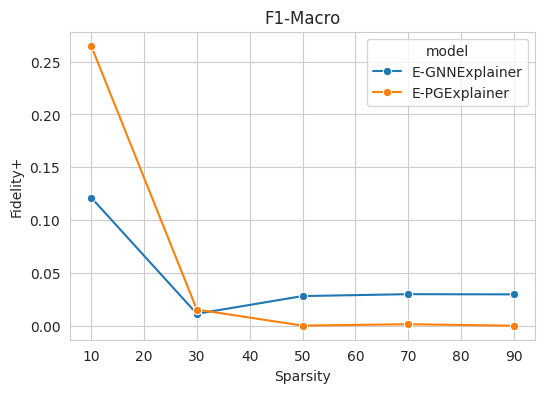

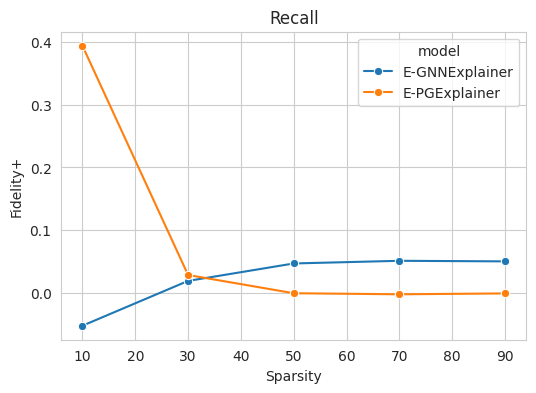

In [ ]:
for class_idx in [0]: #range(4):
  # class_idx = 0
  print("======Class type explaining:", le.inverse_transform([class_idx]),"=============")
  #last
  # acc_ref= 0.994
  f1_macro_ref=last[class_idx]["F1-score"]
  precision_ref=last[class_idx]["Precision"]
  recall_ref=last[class_idx]["Recall"]

  # [('TCP_FLAGS', 0.5615923091769218), ('PROTOCOL', 0.2268944913521409), ('L7_PROTO', 0.02550065517425537), ('FLOW_DURATION_MILLISECONDS', -0.014227990433573723), ('OUT_BYTES', -0.08358267816365697), ('IN_BYTES', -0.426235506311059), ('IN_PKTS', -0.43372365944087504), ('OUT_PKTS', -0.4708433669991791)]
  sorted_list_gnn = sorted_items_gnn[class_idx] #[k for k, v in sorted_items_gnn[class_idx]]
  # sorted_list_gnn

  #for PG
  sorted_list_pg = sorted_items_pg[class_idx] #[k for k, v in sorted_items_pg[class_idx]] #[2,1,4,5,3,0,6,7]
  # sorted_list_pg

  df_results = []
  for i in tqdm(range(10,96,20)):
      print("Running", i)
      df_results.append(train_and_test("E-GNNExplainer", i, sorted_list_gnn, class_idx))


  for i in tqdm(range(10,96,20)):
      print("Running", i)
      df_results.append(train_and_test("E-PGExplainer", i, sorted_list_pg,class_idx))

  pdf_results = pd.DataFrame(df_results)
  # pdf_results["acc_drop"] = (acc_ref - pdf_results["acc"]) / acc_ref
  pdf_results["f1_macro_drop"] = (f1_macro_ref - pdf_results["f1_macro"]) / f1_macro_ref
  pdf_results["precision_drop"] = (precision_ref - pdf_results["precision"]) / precision_ref
  pdf_results["recall_drop"] = (recall_ref - pdf_results["recall"]) / recall_ref

  # pdf_results

  plt.figure(figsize=(6,4))
  sns.set_style(style='whitegrid')
  ax = sns.lineplot(
      data=pdf_results,
      x='dataset',
      y='f1_macro_drop',
      marker="o",
      hue="model"

  )
  #plt.ylim((-0.11),1.25)
  ax.set(xlabel ="Sparsity", ylabel = "Fidelity+", title = "F1-Macro")
  plt.show()
  fig = ax.get_figure()

  plt.figure(figsize=(6,4))
  sns.set_style(style='whitegrid')
  ax = sns.lineplot(
      data=pdf_results, #[(pdf_results.model=="GNNExplainer") | (pdf_results.model=="PGExplainer")],
      x='dataset',
      y='recall_drop',
      marker="o",
      hue="model"

  )
  #plt.ylim((-0.11),1.25)
  ax.set(xlabel ="Sparsity", ylabel = "Fidelity+", title = "Recall")
  plt.show()
  fig = ax.get_figure()


In [ ]:
#20 min for one class eval generation

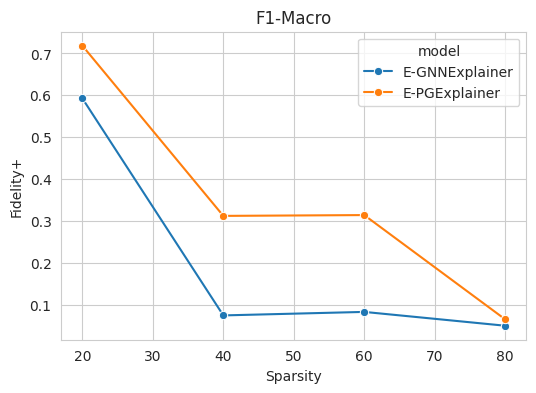

In [ ]:
plt.figure(figsize=(6,4))
sns.set_style(style='whitegrid')
ax = sns.lineplot(
    data=pdf_results, #[(pdf_results.model=="GNNExplainer") | (pdf_results.model=="PGExplainer")],
    x='dataset',
    y='f1_macro_drop',
    marker="o",
    hue="model"

)
#plt.ylim((-0.11),1.25)
ax.set(xlabel ="Sparsity", ylabel = "Fidelity+", title = "F1-Macro")
plt.show()
fig = ax.get_figure()

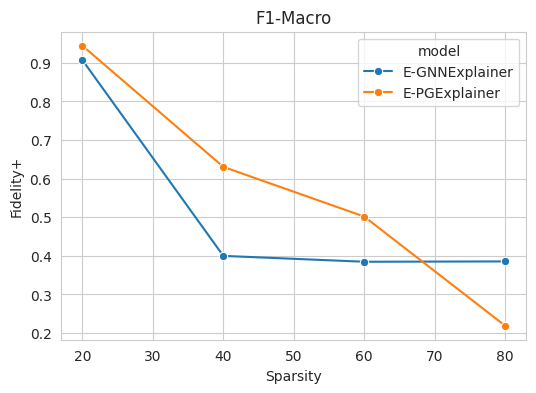

In [ ]:
plt.figure(figsize=(6,4))
sns.set_style(style='whitegrid')
ax = sns.lineplot(
    data=pdf_results, #[(pdf_results.model=="GNNExplainer") | (pdf_results.model=="PGExplainer")],
    x='dataset',
    y='recall_drop',
    marker="o",
    hue="model"

)
#plt.ylim((-0.11),1.25)
ax.set(xlabel ="Sparsity", ylabel = "Fidelity+", title = "Recall")
plt.show()
fig = ax.get_figure()

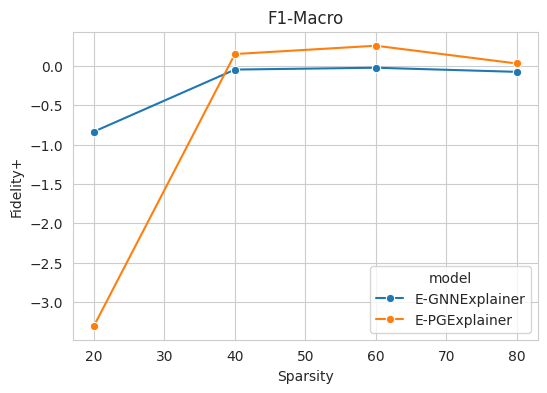

In [ ]:
plt.figure(figsize=(6,4))
sns.set_style(style='whitegrid')
ax = sns.lineplot(
    data=pdf_results, #[(pdf_results.model=="GNNExplainer") | (pdf_results.model=="PGExplainer")],
    x='dataset',
    y='precision_drop',
    marker="o",
    hue="model"

)
#plt.ylim((-0.11),1.25)
ax.set(xlabel ="Sparsity", ylabel = "Fidelity+", title = "Precision")
plt.show()
fig = ax.get_figure()

# OvA Model


In [61]:
global emb
global score_global
emb ={key: [] for key in range(5)}
score_global ={key: [] for key in range(5)}

In [62]:
def compute_accuracy(pred, labels):
    return (pred.argmax(1) == labels).float().mean().item()

class SAGELayer(nn.Module):
    def __init__(self, ndim_in, edims, ndim_out, activation):
        super(SAGELayer, self).__init__()
        ### force to output fix dimensions
        self.W_msg = nn.Linear(ndim_in + edims, ndim_out)
        ### apply weight
        self.W_apply = nn.Linear(ndim_in + ndim_out, ndim_out)
        self.activation = activation

    def message_func(self, edges):
        return {'m': self.W_msg(th.cat([edges.src['h'], edges.data['h']], 2))}

    def forward(self, g_dgl, nfeats,efeats):
        with g_dgl.local_scope():
            g = g_dgl
            g.ndata['h'] = nfeats
            g.edata['h'] = efeats
            # Eq4
            g.update_all(self.message_func, fn.mean('m', 'h_neigh'))
            # Eq5
            g.ndata['h'] = F.relu(self.W_apply(th.cat([g.ndata['h'], g.ndata['h_neigh']], 2)))
            return g.ndata['h']


class SAGE(nn.Module):
    def __init__(self, ndim_in, ndim_out, edim, activation, dropout):
        super(SAGE, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(SAGELayer(ndim_in, edim, 128, activation))
        self.layers.append(SAGELayer(128, edim, ndim_out, activation))
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, g, nfeats, efeats):
        # ipdb.set_trace()
        for i, layer in enumerate(self.layers):
            if i != 0:
                nfeats = self.dropout(nfeats)
            nfeats = layer(g, nfeats, efeats)
        return nfeats.sum(1)

class MLPPredictor(nn.Module):
    def __init__(self, in_features, out_classes):
        super().__init__()
        self.classifiers = nn.ModuleList([nn.Linear(in_features * 2, out_classes) for _ in range(5)])

    def apply_edges(self, edges, class_idx, test,apply_sigmoid=False):
        h_u = edges.src['h']
        h_v = edges.dst['h']
        logits = self.classifiers[class_idx](th.cat([h_u, h_v], 1))
        if apply_sigmoid:
            score = torch.sigmoid(logits) #logits[:,1] #torch.sigmoid(logits)[:,1]
        else:
            score = logits
        # score = logits
        if test:
            emb[class_idx]= th.cat([h_u, h_v], 1)
            score_global[class_idx] = score
        return {'score': score}
    def forward(self, graph, h,test,class_idx=None):
        with graph.local_scope():
            graph.ndata['h'] = h
            if class_idx is not None:
              graph.apply_edges(lambda edges: self.apply_edges(edges, class_idx,test, apply_sigmoid=False))
              return graph.edata['score']
            else:
              outputs = []
              for i in range(len(self.classifiers)):
                  graph.apply_edges(lambda edges: self.apply_edges(edges, i,test,apply_sigmoid=True))
                  outputs.append(graph.edata['score'])
              return torch.stack(outputs, dim=1)

class Model(nn.Module):
    def __init__(self, ndim_in, ndim_out, edim, activation, dropout):
        super().__init__()
        self.gnn = SAGE(ndim_in, ndim_out, edim, activation, dropout)
        self.pred = MLPPredictor(ndim_out, 1)
    def forward(self, g, nfeats,efeats, eweight=None, feature_weight=None, test=False,class_idx=None):
      if eweight != None:
            # apply eweight on the graph
            efe = []
            for i, x in enumerate(eweight):
                efe.append(list(th.Tensor.cpu(g.edata['h'][i][0]).detach().numpy() * th.Tensor.cpu(x).detach().numpy()))

            efe = th.FloatTensor(efe).cuda()
            efe = th.reshape(efe, (efe.shape[0], 1, efe.shape[1]))
            g.edata['h'] = efe = efe
      if feature_weight != None:
          efe= []
          weights = th.tensor(feature_weight,device='cuda')
          # weights = weights.view(1, 1, -1)
          g.edata['h'] *= weights
          efe = g.edata['h']
          g.edata['h'] = efe = efe
          # efeats *= weights
      h = self.gnn(g, nfeats,efeats)
      # return self.pred(g, h)
      if class_idx is not None:
        return self.pred(g, h,test,class_idx)
      else:
        # If no class specified, return predictions for all classes (used for evaluation)
        return self.pred(g, h,test)

In [63]:
from sklearn.utils import class_weight
class_weights_list = []
for i in range(5):
    binary_labels = (G.edata['label'].cpu().numpy() == i).astype(int)
    class_weights = class_weight.compute_class_weight(class_weight ='balanced',
                                                  classes= np.unique(binary_labels),
                                                  y= binary_labels)
    class_weights = th.FloatTensor(class_weights).cuda()
    class_weights_list.append(class_weights)
class_weights_list

[tensor([0.5597, 4.6911], device='cuda:0'),
 tensor([0.8838, 1.1513], device='cuda:0'),
 tensor([0.8266, 1.2654], device='cuda:0'),
 tensor([0.5331, 8.0550], device='cuda:0'),
 tensor([  0.5010, 261.0056], device='cuda:0')]

In [64]:
def train_one_vs_all(model,graph,nfeats, efeats, labels, train_mask, optimizer, num_classes):
    model.train()
    losses = []

    # For each class, train the corresponding binary classifier
    for class_idx in range(num_classes):
        label = le.inverse_transform([class_idx])[0]
        optimizer.zero_grad()
        # Forward pass
        # outputs = model(graph, nfeats, efeats,class_idx=class_idx,feature_weight=final_feature_weights[label]).cuda()
        outputs = model(graph, nfeats, efeats, class_idx=class_idx).cuda()

        #using BCELoss Function
        binary_labels = (labels == class_idx).float()
        criterion = nn.BCEWithLogitsLoss(pos_weight=th.tensor([class_weights_list[class_idx][1]], device=outputs.device))
        loss = criterion(outputs.squeeze()[train_mask], binary_labels[train_mask])

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        del outputs,binary_labels, loss
        th.cuda.empty_cache()

    avg_loss = np.mean(losses)
    return avg_loss


In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

nfeats = G.ndata['h']
efeats = G.edata['h']

edge_label = G.edata['label']
train_mask = G.edata['train_mask']

model = Model(39, 128, 39, F.relu, 0.2).cuda()
opt = th.optim.Adam(model.parameters())

train_losses = []
for epoch in range(1,300):
    avg_loss = train_one_vs_all(model,G,nfeats, efeats,  edge_label, train_mask, opt, 5)
    train_losses.append(avg_loss)
    if epoch % 10 == 0:
        print(avg_loss)

epochs = range(1, 300)
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

0.4702783912420273
0.28450004011392593
0.13712129406630993
0.09381883814930916
0.08253701105713844
0.07845704592764377
0.07619842328131199


In [ ]:
def predict_one_vs_all(model,graph,node_feat, edge_feat):
    model.eval()

    with th.no_grad():
        # Forward pass to get binary classifier outputs for all classes
        outputs = model(graph, nfeats, efeats,test = True)
        # new_df=outputs.cpu().detach().numpy()
        # new_df=pd.DataFrame(outputs.squeeze().cpu())
        # print(outputs.squeeze().shape)
        predicted_classes = th.argmax(outputs, dim=1)  # Select the class with the highest score

    return predicted_classes #, new_df

nfeats = G_test.ndata['feature']
efeats = G_test.edata['h']
predicted_classes = predict_one_vs_all(model,G_test, nfeats ,efeats) #, new_df
predicted_classes.unique()

In [17]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Calculate the precision, recall, F2-score, and support
report = classification_report(le.transform(actual), predicted_classes.cpu(), output_dict=True)

# Print a detailed report for each class
header = f"{'Class':<15}{'Precision':<10}{'Recall':<10}{'F2-score':<10}{'Accuracy':<10}{'Support':<10}"
print(header)
print("=" * len(header))

# Extract and print metrics for each class
for class_name, metrics in report.items():
    if class_name not in ['accuracy', 'macro avg', 'weighted avg']:
        accuracy = metrics['recall']  # For per-class, recall acts as accuracy
        print(f"{class_name:<15}{metrics['precision']:<10.4f}{metrics['recall']:<10.4f}{metrics['f1-score']:<10.4f}{accuracy:<10.4f}{int(metrics['support']):<10}")

# Print overall accuracy
print("\nOverall Accuracy:")
print(f"Accuracy: {report['accuracy']:.4f}")

# Print weighted averages
print("\nWeighted Averages:")
print(report['weighted avg'])

Class          Precision Recall    F2-score  Accuracy  Support   
0              0.6986    0.8297    0.7585    0.8297    81322     
1              0.8162    0.8385    0.8272    0.8385    330546    
2              0.8684    0.7546    0.8075    0.7546    299356    
3              0.6889    0.9035    0.7817    0.9035    47126     
4              0.8295    0.9800    0.8985    0.9800    1400      

Overall Accuracy:
Accuracy: 0.8088

Weighted Averages:
{'precision': 0.8162865668000875, 'recall': 0.8087726225732149, 'f1-score': 0.8093808421515691, 'support': 759750.0}


In [15]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Calculate the precision, recall, F2-score, and support
report = classification_report(le.transform(actual), predicted_classes.cpu(), output_dict=True)

# Print a detailed report for each class
header = f"{'Class':<15}{'Precision':<10}{'Recall':<10}{'F2-score':<10}{'Accuracy':<10}{'Support':<10}"
print(header)
print("=" * len(header))

# Extract and print metrics for each class
for class_name, metrics in report.items():
    if class_name not in ['accuracy', 'macro avg', 'weighted avg']:
        accuracy = metrics['recall']  # For per-class, recall acts as accuracy
        print(f"{class_name:<15}{metrics['precision']:<10.4f}{metrics['recall']:<10.4f}{metrics['f1-score']:<10.4f}{accuracy:<10.4f}{int(metrics['support']):<10}")

# Print overall accuracy
print("\nOverall Accuracy:")
print(f"Accuracy: {report['accuracy']:.4f}")

# Print weighted averages
print("\nWeighted Averages:")
print(report['weighted avg'])

Class          Precision Recall    F2-score  Accuracy  Support   
0              0.9801    0.8454    0.9078    0.8454    81124     
1              0.9941    0.9944    0.9943    0.9944    330036    
2              0.9861    0.9801    0.9831    0.9801    299908    
3              0.7254    0.9196    0.8110    0.9196    47218     
4              0.8543    0.9877    0.9162    0.9877    1466      

Overall Accuracy:
Accuracy: 0.9682

Weighted Averages:
{'precision': 0.9724918041997358, 'recall': 0.9682014657414525, 'f1-score': 0.9690904587925595, 'support': 759752.0}


In [ ]:
#with randomized IPs
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Calculate the precision, recall, F2-score, and support
report = classification_report(le.inverse_transform(actual), le.inverse_transform(predicted_classes.cpu()), output_dict=True)

# Print a detailed report for each class
header = f"{'Class':<15}{'Precision':<10}{'Recall':<10}{'F2-score':<10}{'Accuracy':<10}{'Support':<10}"
print(header)
print("=" * len(header))

# Extract and print metrics for each class
for class_name, metrics in report.items():
    if class_name not in ['accuracy', 'macro avg', 'weighted avg']:
        accuracy = metrics['recall']  # For per-class, recall acts as accuracy
        print(f"{class_name:<15}{metrics['precision']:<10.4f}{metrics['recall']:<10.4f}{metrics['f1-score']:<10.4f}{accuracy:<10.4f}{int(metrics['support']):<10}")

# Print overall accuracy
print("\nOverall Accuracy:")
print(f"Accuracy: {report['accuracy']:.4f}")

# Print weighted averages
print("\nWeighted Averages:")
print(report['weighted avg'])

In [ ]:
# 0.04899469199972373 seconds
# Class          Precision Recall    F2-score  Accuracy  Support
# =================================================================
# Benign         0.6681    0.8821    0.7603    0.8821    81322
# DDoS           0.8765    0.7440    0.8048    0.7440    330546
# DoS            0.8133    0.8285    0.8208    0.8285    299356
# Reconnaissance 0.6643    0.9179    0.7708    0.9179    47126
# Theft          0.8018    0.9914    0.8866    0.9914    1400

# Overall Accuracy:
# Accuracy: 0.8033

# Weighted Averages:
# {'precision': 0.8159823057384913, 'recall': 0.8033155643303719, 'f1-score': 0.8044054985334977, 'support': 759750.0}

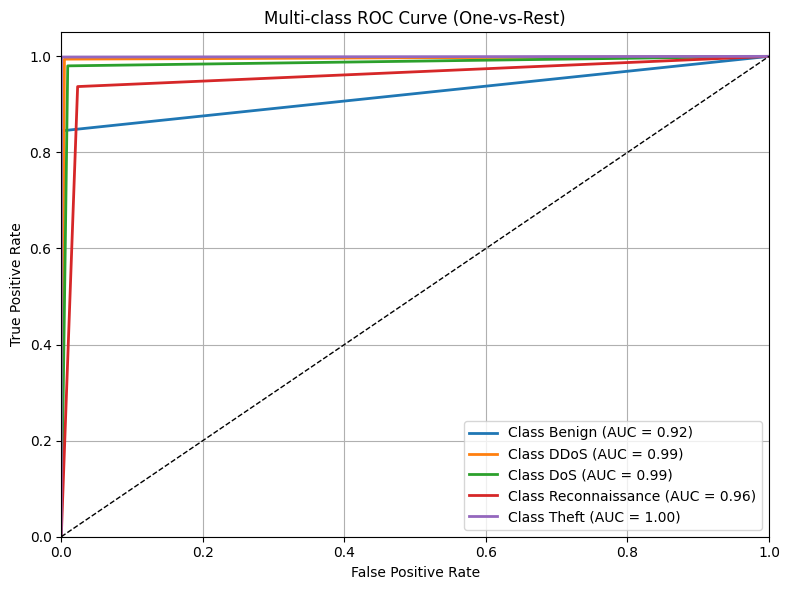

In [ ]:
X = actual
y = le.inverse_transform(predicted_classes.cpu())
classes = np.unique(actual)
n_classes = len(classes)

X_bin = label_binarize(X, classes=classes)  # shape: (n_samples, n_classes)
y_bin = label_binarize(y, classes=classes)  # shape: (n_samples, n_classes)

# 2. Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(X_bin[:, i], y_bin[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"Class {classes[i]} (AUC = {roc_auc:.2f})")

# 3. Add plot decorations
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve (One-vs-Rest)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


In [44]:
def compute_accuracy(pred, labels):
    return (pred.argmax(1) == labels).float().mean().item()

class SAGELayer(nn.Module):
    def __init__(self, ndim_in, edims, ndim_out, activation):
        super(SAGELayer, self).__init__()
        ### force to output fix dimensions
        self.W_msg = nn.Linear(ndim_in + edims, ndim_out)
        ### apply weight
        self.W_apply = nn.Linear(ndim_in + ndim_out, ndim_out)
        self.activation = activation

    def message_func(self, edges):
        return {'m': self.W_msg(th.cat([edges.src['h'], edges.data['h']], 2))}

    def forward(self, g_dgl, nfeats,efeats):
        with g_dgl.local_scope():
            g = g_dgl
            g.ndata['h'] = nfeats
            g.edata['h'] = efeats
            # Eq4
            g.update_all(self.message_func, fn.mean('m', 'h_neigh'))
            # Eq5
            g.ndata['h'] = F.relu(self.W_apply(th.cat([g.ndata['h'], g.ndata['h_neigh']], 2)))
            return g.ndata['h']


class SAGE(nn.Module):
    def __init__(self, ndim_in, ndim_out, edim, activation, dropout):
        super(SAGE, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(SAGELayer(ndim_in, edim, 128, activation))
        self.layers.append(SAGELayer(128, edim, ndim_out, activation))
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, g, nfeats, efeats):
        # ipdb.set_trace()
        for i, layer in enumerate(self.layers):
            if i != 0:
                nfeats = self.dropout(nfeats)
            nfeats = layer(g, nfeats, efeats)
        return nfeats.sum(1)

class MLPPredictor(nn.Module):
    def __init__(self, in_features, out_classes):
        super().__init__()
        self.classifiers = nn.ModuleList([nn.Linear(in_features * 2, out_classes) for _ in range(5)])

    def apply_edges(self, edges, class_idx, apply_sigmoid=False):
        h_u = edges.src['h']
        h_v = edges.dst['h']
        logits = self.classifiers[class_idx](th.cat([h_u, h_v], 1))
        # if apply_sigmoid:
        #     score = logits[:,1] #torch.sigmoid(logits)[:,1]
        # else:
        #     score = logits
        score = logits
        return {'score': score}
    def forward(self, graph, h, class_idx=None):
        with graph.local_scope():
            graph.ndata['h'] = h
            if class_idx is not None:
              graph.apply_edges(lambda edges: self.apply_edges(edges, class_idx,apply_sigmoid=False))
              return graph.edata['score']
            else:
              outputs = []
              for i in range(len(self.classifiers)):
                  graph.apply_edges(lambda edges: self.apply_edges(edges, i,apply_sigmoid=True))
                  outputs.append(graph.edata['score'])
              return torch.stack(outputs, dim=1)

class Model(nn.Module):
    def __init__(self, ndim_in, ndim_out, edim, activation, dropout):
        super().__init__()
        self.gnn = SAGE(ndim_in, ndim_out, edim, activation, dropout)
        self.pred = MLPPredictor(ndim_out, 1)
    def forward(self, g, nfeats,efeats, edge_weight=None, feature_weight=None,class_idx=None):
      h = self.gnn(g, nfeats,efeats)
      # return self.pred(g, h)
      if class_idx is not None:
        return self.pred(g, h, class_idx)
      else:
        # If no class specified, return predictions for all classes (used for evaluation)
        return self.pred(g, h)

In [45]:
# selected_features_per_class=final_features
# for e -gnn
# selected_features_per_class ={0: [34, 2, 13, 0, 21, 10, 24, 15, 1, 7, 11, 12, 4, 30, 38, 22, 28, 31, 37, 5], 1: [21, 34, 24, 7, 2, 13, 37, 12, 11, 27, 5, 19, 36, 28, 22, 17, 1, 9, 38, 31], 2: [34, 14, 8, 5, 22, 12, 15, 4, 17, 31, 27, 0, 38, 11, 6, 19, 2, 36, 37, 28], 3: [2, 33, 35, 29, 20, 16, 32, 3, 18, 25, 37, 7, 26, 23, 5, 14, 24, 17, 4, 36], 4: [16, 34, 29, 5, 33, 11, 10, 21, 30, 15, 7, 1, 19, 0, 27, 23, 9, 13, 24, 3]}

#for e-pg
selected_features_per_class = {0: [0, 28, 36, 37, 22, 33, 31, 8, 17, 11, 5, 6, 2, 10, 4, 38, 1, 19, 12, 21, 7, 34, 14, 29, 23, 35, 32, 20, 9, 3, 30, 24, 15, 18, 27, 16, 26, 25, 13], 1: [13, 2, 34, 4, 3, 36, 6, 12, 16, 8, 24, 38, 1, 11, 15, 28, 23, 35, 32, 37, 19, 25, 21, 9, 22, 14, 10, 20, 27, 18, 7, 26, 31, 0, 5, 17, 30, 29, 33], 2: [18, 4, 15, 5, 37, 19, 20, 33, 11, 13, 16, 25, 29, 23, 24, 3, 26, 8, 1, 17, 38, 21, 30, 9, 12, 10, 7, 0, 28, 2, 22, 27, 14, 34, 31, 6, 35, 32, 36], 3: [18, 21, 35, 15, 22, 30, 14, 8, 12, 6, 2, 33, 38, 16, 26, 20, 29, 0, 28, 27, 19, 1, 25, 34, 32, 11, 36, 13, 5, 24, 17, 9, 37, 4, 3, 7, 31, 23, 10], 4: [8, 11, 17, 24, 19, 14, 36, 4, 15, 25, 37, 20, 34, 5, 0, 9, 10, 33, 18, 32, 38, 1, 2, 3, 22, 26, 29, 30, 7, 31, 23, 28, 21, 27, 16, 12, 35, 6, 13]}

#  {0: [7, 14, 19, 36, 21, 37, 33, 22, 35, 27, 3, 34, 18, 11, 38, 15, 29, 30, 10, 2], 1: [31, 15, 14, 29, 5, 10, 33, 12, 19, 34, 16, 20, 27, 35, 11, 1, 17, 0, 4, 25], 2: [23, 5, 31, 14, 3, 30, 29, 34, 0, 24, 28, 2, 16, 6, 12, 7, 9, 15, 8, 19], 3: [28, 3, 14, 11, 5, 16, 38, 29, 2, 36, 20, 35, 18, 1, 26, 15, 19, 0, 8, 25], 4: [33, 12, 3, 1, 27, 35, 32, 16, 14, 18, 30, 34, 9, 29, 26, 15, 25, 11, 22, 6]}



In [46]:
num = 25
selected_features_per_class_15 =selected_features_per_class
for key in selected_features_per_class_15:
    selected_features_per_class_15[key] = selected_features_per_class_15[key][:num]
selected_features_per_class= selected_features_per_class_15
selected_features_per_class

{0: [0,
  28,
  36,
  37,
  22,
  33,
  31,
  8,
  17,
  11,
  5,
  6,
  2,
  10,
  4,
  38,
  1,
  19,
  12,
  21,
  7,
  34,
  14,
  29,
  23],
 1: [13,
  2,
  34,
  4,
  3,
  36,
  6,
  12,
  16,
  8,
  24,
  38,
  1,
  11,
  15,
  28,
  23,
  35,
  32,
  37,
  19,
  25,
  21,
  9,
  22],
 2: [18,
  4,
  15,
  5,
  37,
  19,
  20,
  33,
  11,
  13,
  16,
  25,
  29,
  23,
  24,
  3,
  26,
  8,
  1,
  17,
  38,
  21,
  30,
  9,
  12],
 3: [18,
  21,
  35,
  15,
  22,
  30,
  14,
  8,
  12,
  6,
  2,
  33,
  38,
  16,
  26,
  20,
  29,
  0,
  28,
  27,
  19,
  1,
  25,
  34,
  32],
 4: [8,
  11,
  17,
  24,
  19,
  14,
  36,
  4,
  15,
  25,
  37,
  20,
  34,
  5,
  0,
  9,
  10,
  33,
  18,
  32,
  38,
  1,
  2,
  3,
  22]}

In [49]:
def train_one_vs_all(model,graph,nfeats, efeats, labels, train_mask, optimizer, num_classes):
    model.train()
    losses = []

    # For each class, train the corresponding binary classifier
    for class_idx in range(num_classes):
        optimizer.zero_grad()
        selected_efeatures = efeats[:, :, selected_features_per_class[class_idx]]
        selected_nfeatures = nfeats[:, :, selected_features_per_class[class_idx]]

        # Forward pass
        outputs = model(graph, selected_nfeatures, selected_efeatures,class_idx=class_idx).cuda()

        #using BCELoss Function
        binary_labels = (labels == class_idx).float()
        criterion = nn.BCEWithLogitsLoss(pos_weight=th.tensor([class_weights_list[class_idx][1]], device=outputs.device))
        loss = criterion(outputs.squeeze()[train_mask], binary_labels[train_mask])

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        del outputs,binary_labels, loss
        th.cuda.empty_cache()

    avg_loss = np.mean(losses)
    return avg_loss


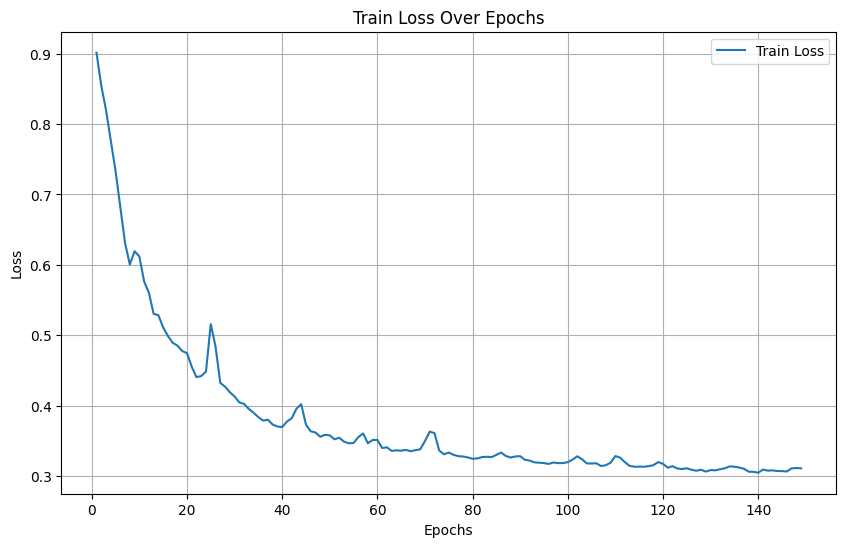

In [51]:
PGExplainer 20 features
nfeats = G.ndata['h']
efeats = G.edata['h']

edge_label = G.edata['label']
train_mask = G.edata['train_mask']

model = Model(num, 128, num, F.relu, 0.2).cuda()
opt = th.optim.Adam(model.parameters())

train_losses = []
for epoch in range(1,150):
    avg_loss = train_one_vs_all(model,G,nfeats, efeats,  edge_label, train_mask, opt, 5)
    train_losses.append(avg_loss)
    if epoch % 10 == 0:
        print(avg_loss)

epochs = range(1, 150)
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# pg explainer 15
nfeats = G.ndata['h']
efeats = G.edata['h']

edge_label = G.edata['label']
train_mask = G.edata['train_mask']

model = Model(25, 128, 25, F.relu, 0.2).cuda()
opt = th.optim.Adam(model.parameters())

train_losses = []
for epoch in range(1,100):
    avg_loss = train_one_vs_all(model,G,nfeats, efeats,  edge_label, train_mask, opt, 5)
    train_losses.append(avg_loss)
    if epoch % 10 == 0:
        print(avg_loss)

epochs = range(1, 100)
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# for e-gnn expplainer 15 features
nfeats = G.ndata['h']
efeats = G.edata['h']

edge_label = G.edata['label']
train_mask = G.edata['train_mask']

model = Model(15, 128, 15, F.relu, 0.2).cuda()
opt = th.optim.Adam(model.parameters())

train_losses = []
for epoch in range(1,100):
    avg_loss = train_one_vs_all(model,G,nfeats, efeats,  edge_label, train_mask, opt, 5)
    train_losses.append(avg_loss)
    if epoch % 10 == 0:
        print(avg_loss)

epochs = range(1, 100)
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [52]:
def predict_one_vs_all(model,graph,node_feat, edge_feat):
    model.eval()

    with th.no_grad():
        outputs = []
        for class_idx in range(5):
          selected_efeatures = efeats[:, :, selected_features_per_class[class_idx]]
          selected_nfeatures = nfeats[:, :, selected_features_per_class[class_idx]]

          logits = model(graph, selected_nfeatures, selected_efeatures, class_idx=class_idx).cuda()

          outputs.append(logits)#torch.sigmoid(logits)[:,0]

        outputs = th.stack(outputs, dim=1)  # Shape: (num_nodes, num_classes)
        predicted_classes = th.argmax(outputs, dim=1)  # Select the class with the highest score

    return predicted_classes

nfeats = G_test.ndata['feature']
efeats = G_test.edata['h']
predicted_classes = predict_one_vs_all(model,G_test, nfeats ,efeats)
predicted_classes.unique()

tensor([0, 1, 2, 3, 4], device='cuda:0')

In [ ]:
#PGExplainer 35 features
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Calculate the precision, recall, F2-score, and support
report = classification_report(le.inverse_transform(actual), le.inverse_transform(predicted_classes.cpu()), output_dict=True)

# Print a detailed report for each class
header = f"{'Class':<15}{'Precision':<10}{'Recall':<10}{'F2-score':<10}{'Accuracy':<10}{'Support':<10}"
print(header)
print("=" * len(header))

# Extract and print metrics for each class
for class_name, metrics in report.items():
    if class_name not in ['accuracy', 'macro avg', 'weighted avg']:
        accuracy = metrics['recall']  # For per-class, recall acts as accuracy
        print(f"{class_name:<15}{metrics['precision']:<10.2f}{metrics['recall']:<10.2f}{metrics['f1-score']:<10.2f}{accuracy:<10.3f}{int(metrics['support']):<10}")

# Print overall accuracy
print("\nOverall Accuracy:")
print(f"Accuracy: {report['accuracy']:.2f}")

# Print weighted averages
print("\nWeighted Averages:")
print(report['weighted avg'])

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Class          Precision Recall    F2-score  Accuracy  Support   
Benign         0.97      0.81      0.88      0.808     5982      
DDoS           0.99      0.99      0.99      0.995     5938      
DoS            0.95      0.98      0.96      0.977     6092      
Reconnaissance 0.82      0.93      0.87      0.925     5970      
Theft          0.98      0.99      0.99      0.995     1478      

Overall Accuracy:
Accuracy: 0.93

Weighted Averages:
{'precision': 0.9353488316701388, 'recall': 0.9302827965435978, 'f1-score': 0.9301509176048884, 'support': 25460.0}


In [ ]:
#PGExplainer 30 features
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Calculate the precision, recall, F2-score, and support
report = classification_report(le.inverse_transform(actual), le.inverse_transform(predicted_classes.cpu()), output_dict=True)

# Print a detailed report for each class
header = f"{'Class':<15}{'Precision':<10}{'Recall':<10}{'F2-score':<10}{'Accuracy':<10}{'Support':<10}"
print(header)
print("=" * len(header))

# Extract and print metrics for each class
for class_name, metrics in report.items():
    if class_name not in ['accuracy', 'macro avg', 'weighted avg']:
        accuracy = metrics['recall']  # For per-class, recall acts as accuracy
        print(f"{class_name:<15}{metrics['precision']:<10.2f}{metrics['recall']:<10.2f}{metrics['f1-score']:<10.2f}{accuracy:<10.3f}{int(metrics['support']):<10}")

# Print overall accuracy
print("\nOverall Accuracy:")
print(f"Accuracy: {report['accuracy']:.2f}")

# Print weighted averages
print("\nWeighted Averages:")
print(report['weighted avg'])

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Class          Precision Recall    F2-score  Accuracy  Support   
Benign         0.93      0.79      0.85      0.785     5982      
DDoS           0.99      0.99      0.99      0.995     5938      
DoS            0.95      0.96      0.95      0.959     6092      
Reconnaissance 0.79      0.94      0.86      0.938     5970      
Theft          0.95      0.80      0.87      0.804     1478      

Overall Accuracy:
Accuracy: 0.91

Weighted Averages:
{'precision': 0.9182915241229324, 'recall': 0.9124901806755695, 'f1-score': 0.9122039802802786, 'support': 25460.0}


In [57]:
#PGExplainer 25 features
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Calculate the precision, recall, F2-score, and support
report = classification_report(actual, le.inverse_transform(predicted_classes.cpu()), output_dict=True)

# Print a detailed report for each class
header = f"{'Class':<15}{'Precision':<10}{'Recall':<10}{'F2-score':<10}{'Accuracy':<10}{'Support':<10}"
print(header)
print("=" * len(header))

# Extract and print metrics for each class
for class_name, metrics in report.items():
    if class_name not in ['accuracy', 'macro avg', 'weighted avg']:
        accuracy = metrics['recall']  # For per-class, recall acts as accuracy
        print(f"{class_name:<15}{metrics['precision']:<10.2f}{metrics['recall']:<10.2f}{metrics['f1-score']:<10.2f}{accuracy:<10.3f}{int(metrics['support']):<10}")

# Print overall accuracy
print("\nOverall Accuracy:")
print(f"Accuracy: {report['accuracy']:.2f}")

# Print weighted averages
print("\nWeighted Averages:")
print(report['weighted avg'])

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Class          Precision Recall    F2-score  Accuracy  Support   
Benign         0.74      0.78      0.76      0.784     81322     
DDoS           0.85      0.78      0.82      0.781     330546    
DoS            0.81      0.82      0.82      0.825     299356    
Reconnaissance 0.67      0.91      0.78      0.915     47126     
Theft          0.46      0.99      0.62      0.989     1400      

Overall Accuracy:
Accuracy: 0.81

Weighted Averages:
{'precision': 0.8129404527780564, 'recall': 0.8072155314248108, 'f1-score': 0.8079942332638882, 'support': 759750.0}


In [58]:
# Class          Precision Recall    F2-score  Accuracy  Support
# =================================================================
# Benign         0.6681    0.8821    0.7603    0.8821    81322
# DDoS           0.8765    0.7440    0.8048    0.7440    330546
# DoS            0.8133    0.8285    0.8208    0.8285    299356
# Reconnaissance 0.6643    0.9179    0.7708    0.9179    47126
# Theft          0.8018    0.9914    0.8866    0.9914    1400

# Overall Accuracy:
# Accuracy: 0.8033

# Weighted Averages:
# {'precision': 0.8159823057384913, 'recall': 0.8033155643303719, 'f1-score': 0.8044054985334977, 'support': 759750.0}

In [ ]:
#PGExplainer 20 features
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Calculate the precision, recall, F2-score, and support
report = classification_report(le.inverse_transform(actual), le.inverse_transform(predicted_classes.cpu()), output_dict=True)

# Print a detailed report for each class
header = f"{'Class':<15}{'Precision':<10}{'Recall':<10}{'F2-score':<10}{'Accuracy':<10}{'Support':<10}"
print(header)
print("=" * len(header))

# Extract and print metrics for each class
for class_name, metrics in report.items():
    if class_name not in ['accuracy', 'macro avg', 'weighted avg']:
        accuracy = metrics['recall']  # For per-class, recall acts as accuracy
        print(f"{class_name:<15}{metrics['precision']:<10.2f}{metrics['recall']:<10.2f}{metrics['f1-score']:<10.2f}{accuracy:<10.3f}{int(metrics['support']):<10}")

# Print overall accuracy
print("\nOverall Accuracy:")
print(f"Accuracy: {report['accuracy']:.2f}")

# Print weighted averages
print("\nWeighted Averages:")
print(report['weighted avg'])

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Class          Precision Recall    F2-score  Accuracy  Support   
Benign         0.93      0.81      0.87      0.812     5982      
DDoS           0.99      0.99      0.99      0.995     5938      
DoS            0.95      0.94      0.95      0.944     6092      
Reconnaissance 0.81      0.94      0.87      0.936     5970      
Theft          0.93      0.80      0.86      0.804     1478      

Overall Accuracy:
Accuracy: 0.91

Weighted Averages:
{'precision': 0.919522143446382, 'recall': 0.9148468185388845, 'f1-score': 0.9148183065234721, 'support': 25460.0}


In [ ]:
#pg explainer 15 features
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Calculate the precision, recall, F2-score, and support
report = classification_report(le.inverse_transform(actual), le.inverse_transform(predicted_classes.cpu()), output_dict=True)

# Print a detailed report for each class
header = f"{'Class':<15}{'Precision':<10}{'Recall':<10}{'F2-score':<10}{'Accuracy':<10}{'Support':<10}"
print(header)
print("=" * len(header))

# Extract and print metrics for each class
for class_name, metrics in report.items():
    if class_name not in ['accuracy', 'macro avg', 'weighted avg']:
        accuracy = metrics['recall']  # For per-class, recall acts as accuracy
        print(f"{class_name:<15}{metrics['precision']:<10.2f}{metrics['recall']:<10.2f}{metrics['f1-score']:<10.2f}{accuracy:<10.3f}{int(metrics['support']):<10}")

# Print overall accuracy
print("\nOverall Accuracy:")
print(f"Accuracy: {report['accuracy']:.2f}")

# Print weighted averages
print("\nWeighted Averages:")
print(report['weighted avg'])

In [ ]:
# for e-gnn explainer 15 features
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Calculate the precision, recall, F2-score, and support
report = classification_report(le.inverse_transform(actual), le.inverse_transform(predicted_classes.cpu()), output_dict=True)

# Print a detailed report for each class
header = f"{'Class':<15}{'Precision':<10}{'Recall':<10}{'F2-score':<10}{'Accuracy':<10}{'Support':<10}"
print(header)
print("=" * len(header))

# Extract and print metrics for each class
for class_name, metrics in report.items():
    if class_name not in ['accuracy', 'macro avg', 'weighted avg']:
        accuracy = metrics['recall']  # For per-class, recall acts as accuracy
        print(f"{class_name:<15}{metrics['precision']:<10.2f}{metrics['recall']:<10.2f}{metrics['f1-score']:<10.2f}{accuracy:<10.3f}{int(metrics['support']):<10}")

# Print overall accuracy
print("\nOverall Accuracy:")
print(f"Accuracy: {report['accuracy']:.2f}")

# Print weighted averages
print("\nWeighted Averages:")
print(report['weighted avg'])

In [ ]:
# for e-gnn explainer 25 features
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Calculate the precision, recall, F2-score, and support
report = classification_report(actual, le.inverse_transform(predicted_classes.cpu()), output_dict=True)

# Print a detailed report for each class
header = f"{'Class':<15}{'Precision':<10}{'Recall':<10}{'F2-score':<10}{'Accuracy':<10}{'Support':<10}"
print(header)
print("=" * len(header))

# Extract and print metrics for each class
for class_name, metrics in report.items():
    if class_name not in ['accuracy', 'macro avg', 'weighted avg']:
        accuracy = metrics['recall']  # For per-class, recall acts as accuracy
        print(f"{class_name:<15}{metrics['precision']:<10.2f}{metrics['recall']:<10.2f}{metrics['f1-score']:<10.2f}{accuracy:<10.3f}{int(metrics['support']):<10}")

# Print overall accuracy
print("\nOverall Accuracy:")
print(f"Accuracy: {report['accuracy']:.2f}")

# Print weighted averages
print("\nWeighted Averages:")
print(report['weighted avg'])

# OvA - With Class wise features

In [54]:
def compute_accuracy(pred, labels):
    return (pred.argmax(1) == labels).float().mean().item()

class SAGELayer(nn.Module):
    def __init__(self, ndim_in, edims, ndim_out, activation):
        super(SAGELayer, self).__init__()
        ### force to output fix dimensions
        self.W_msg = nn.Linear(ndim_in + edims, ndim_out)
        ### apply weight
        self.W_apply = nn.Linear(ndim_in + ndim_out, ndim_out)
        self.activation = activation

    def message_func(self, edges):
        return {'m': self.W_msg(th.cat([edges.src['h'], edges.data['h']], 2))}

    def forward(self, g_dgl, nfeats,efeats):
        with g_dgl.local_scope():
            g = g_dgl
            g.ndata['h'] = nfeats
            g.edata['h'] = efeats
            # Eq4
            g.update_all(self.message_func, fn.mean('m', 'h_neigh'))
            # Eq5
            g.ndata['h'] = F.relu(self.W_apply(th.cat([g.ndata['h'], g.ndata['h_neigh']], 2)))
            return g.ndata['h']


class SAGE(nn.Module):
    def __init__(self, ndim_in, ndim_out, edim, activation, dropout):
        super(SAGE, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(SAGELayer(ndim_in, edim, 128, activation))
        self.layers.append(SAGELayer(128, edim, ndim_out, activation))
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, g, nfeats, efeats):
        # ipdb.set_trace()
        for i, layer in enumerate(self.layers):
            if i != 0:
                nfeats = self.dropout(nfeats)
            nfeats = layer(g, nfeats, efeats)
        return nfeats.sum(1)

class MLPPredictor(nn.Module):
    def __init__(self, in_features, out_classes):
        super().__init__()
        self.classifiers = nn.ModuleList([nn.Linear(in_features * 2, out_classes) for _ in range(5)])

    def apply_edges(self, edges, class_idx, apply_sigmoid=False):
        h_u = edges.src['h']
        h_v = edges.dst['h']
        logits = self.classifiers[class_idx](th.cat([h_u, h_v], 1))
        # if apply_sigmoid:
        #     score = logits[:,1] #torch.sigmoid(logits)[:,1]
        # else:
        #     score = logits
        score = logits
        return {'score': score}
    def forward(self, graph, h, class_idx=None):
        with graph.local_scope():
            graph.ndata['h'] = h
            if class_idx is not None:
              graph.apply_edges(lambda edges: self.apply_edges(edges, class_idx,apply_sigmoid=False))
              return graph.edata['score']
            else:
              outputs = []
              for i in range(len(self.classifiers)):
                  graph.apply_edges(lambda edges: self.apply_edges(edges, i,apply_sigmoid=True))
                  outputs.append(graph.edata['score'])
              return torch.stack(outputs, dim=1)

class Model(nn.Module):
    def __init__(self, ndim_in, ndim_out, edim, activation, dropout):
        super().__init__()
        self.gnn = SAGE(ndim_in, ndim_out, edim, activation, dropout)
        self.pred = MLPPredictor(ndim_out, 1)
    def forward(self, g, nfeats,efeats, edge_weight=None, feature_weight=None,class_idx=None):
      h = self.gnn(g, nfeats,efeats)
      # return self.pred(g, h)
      if class_idx is not None:
        return self.pred(g, h, class_idx)
      else:
        # If no class specified, return predictions for all classes (used for evaluation)
        return self.pred(g, h)

In [55]:
class_weights_list = []
for i in range(5):
    binary_labels = (G.edata['label'].cpu().numpy() == i).astype(int)
    class_weights = class_weight.compute_class_weight(class_weight ='balanced',
                                                  classes= np.unique(binary_labels),
                                                  y= binary_labels)
    class_weights = th.FloatTensor(class_weights).cuda()
    class_weights_list.append(class_weights)
class_weights_list

[tensor([0.5597, 4.6911], device='cuda:0'),
 tensor([0.8838, 1.1513], device='cuda:0'),
 tensor([0.8266, 1.2654], device='cuda:0'),
 tensor([0.5331, 8.0550], device='cuda:0'),
 tensor([  0.5010, 261.0056], device='cuda:0')]

In [56]:
def train_one_vs_all(model,graph,nfeats, efeats, labels, train_mask, optimizer, num_classes, selected_features_per_class):
    model.train()
    losses = []

    # For each class, train the corresponding binary classifier
    for class_idx in range(num_classes):
        optimizer.zero_grad()
        selected_efeatures = efeats[:, :, selected_features_per_class[class_idx]]
        selected_nfeatures = nfeats[:, :, selected_features_per_class[class_idx]]

        # Forward pass
        outputs = model(graph, selected_nfeatures, selected_efeatures,class_idx=class_idx).cuda()

        #using BCELoss Function
        binary_labels = (labels == class_idx).float()
        criterion = nn.BCEWithLogitsLoss(pos_weight=th.tensor([class_weights_list[class_idx][1]], device=outputs.device))
        loss = criterion(outputs.squeeze()[train_mask], binary_labels[train_mask])

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        del outputs,binary_labels, loss
        th.cuda.empty_cache()

    avg_loss = np.mean(losses)
    return avg_loss


In [57]:
def predict_one_vs_all(model,graph,nfeats, efeats,selected_features_per_class):
    model.eval()

    with th.no_grad():
        outputs = []
        for class_idx in range(5):
          selected_efeatures = efeats[:, :, selected_features_per_class[class_idx]]
          selected_nfeatures = nfeats[:, :, selected_features_per_class[class_idx]]

          logits = model(graph, selected_nfeatures, selected_efeatures, class_idx=class_idx).cuda()

          outputs.append(logits)#torch.sigmoid(logits)[:,0]

        outputs = th.stack(outputs, dim=1)  # Shape: (num_nodes, num_classes)
        predicted_classes = th.argmax(outputs, dim=1)  # Select the class with the highest score

    return predicted_classes

# nfeats = G_test.ndata['feature']
# efeats = G_test.edata['h']
# predicted_classes = predict_one_vs_all(model,G_test, nfeats ,efeats)
# predicted_classes.unique()

In [58]:
# selected_features_per_class=final_features
# for e -gnn
selected_features_per_class_gnn ={0: [38, 6, 37, 24, 1, 31, 20, 4, 18, 5, 32, 25, 9, 19, 16, 23, 34, 2, 17, 7, 13, 28, 10, 27, 29, 33, 0, 15, 3, 12, 26, 22, 36, 21, 30, 35, 11, 8, 14], 1: [37, 28, 34, 13, 1, 9, 23, 20, 0, 29, 2, 31, 33, 6, 38, 12, 15, 8, 27, 22, 36, 19, 24, 7, 17, 4, 11, 3, 25, 35, 18, 16, 5, 32, 14, 21, 30, 26, 10], 2: [21, 10, 6, 18, 31, 9, 19, 35, 5, 3, 26, 25, 24, 16, 32, 30, 33, 11, 12, 4, 38, 8, 37, 7, 1, 13, 17, 29, 20, 27, 36, 22, 34, 2, 0, 28, 15, 23, 14], 3: [6, 33, 32, 14, 16, 26, 25, 3, 30, 23, 17, 15, 8, 24, 18, 29, 37, 4, 21, 11, 19, 35, 5, 28, 38, 13, 10, 2, 31, 9, 36, 27, 22, 34, 20, 12, 7, 0, 1], 4: [30, 21, 3, 8, 26, 1, 18, 15, 35, 16, 25, 4, 12, 17, 23, 11, 28, 24, 38, 5, 29, 14, 31, 9, 0, 37, 34, 6, 32, 27, 22, 36, 19, 7, 33, 2, 20, 10, 13]}
# {0: [24, 6, 9, 26, 16, 5, 33, 1, 23, 27, 7, 11, 2, 14, 0, 31, 18, 3, 28, 36, 32, 13, 8, 20, 35, 4, 34, 25, 30, 38, 22, 15, 17, 12, 29, 21, 37, 19, 10], 1: [26, 4, 32, 29, 19, 5, 6, 3, 20, 38, 10, 30, 24, 17, 36, 18, 2, 34, 31, 1, 35, 0, 8, 27, 23, 25, 7, 33, 13, 15, 28, 14, 9, 16, 37, 11, 12, 22, 21], 2: [32, 38, 20, 19, 8, 35, 12, 22, 25, 0, 10, 1, 28, 17, 11, 3, 36, 16, 9, 33, 18, 24, 30, 31, 21, 23, 13, 5, 34, 14, 27, 7, 26, 37, 4, 2, 6, 29, 15], 3: [10, 8, 27, 38, 0, 30, 17, 15, 34, 11, 36, 20, 13, 19, 37, 31, 18, 12, 22, 4, 35, 3, 2, 33, 24, 29, 16, 26, 21, 9, 23, 25, 28, 1, 32, 5, 6, 14, 7], 4: [5, 37, 12, 11, 8, 10, 29, 18, 26, 36, 31, 17, 7, 38, 32, 21, 14, 19, 1, 20, 3, 27, 22, 25, 9, 13, 30, 24, 16, 33, 35, 28, 34, 2, 15, 23, 6, 0, 4]}
# {0: [25, 7, 19, 38, 8, 29, 9, 0, 35, 18, 32, 12, 34, 16, 20, 10, 28, 17, 27, 24, 31, 3, 26, 5, 15, 1, 2, 14, 23, 36, 37, 13, 11, 4, 30, 6, 21, 22, 33], 1: [31, 19, 7, 29, 32, 25, 9, 10, 1, 8, 28, 0, 34, 12, 35, 18, 20, 15, 27, 38, 16, 11, 14, 3, 13, 5, 22, 37, 26, 30, 2, 24, 17, 36, 4, 23, 21, 6, 33], 2: [35, 3, 34, 9, 24, 38, 32, 25, 26, 0, 18, 16, 20, 7, 14, 31, 19, 21, 29, 36, 37, 5, 8, 27, 28, 17, 15, 12, 11, 10, 1, 2, 23, 4, 6, 22, 13, 33, 30], 3: [35, 8, 21, 14, 27, 9, 25, 20, 15, 38, 24, 11, 37, 18, 0, 36, 16, 17, 7, 34, 23, 26, 33, 2, 32, 5, 31, 12, 29, 22, 10, 3, 19, 4, 13, 28, 6, 1, 30], 4: [8, 35, 15, 27, 38, 20, 24, 36, 37, 16, 21, 25, 1, 9, 14, 0, 11, 18, 17, 30, 6, 31, 23, 34, 26, 28, 32, 7, 2, 4, 12, 33, 29, 5, 10, 19, 22, 13, 3]}


#for e-pg
selected_features_per_class_pg = {0: [32, 38, 30, 20, 2, 18, 5, 13, 29, 3, 15, 4, 19, 17, 6, 9, 34, 31, 22, 25, 24, 27, 26, 35, 0, 14, 11, 33, 10, 16, 7, 23, 36, 21, 12, 37, 8, 28, 1], 1: [15, 27, 10, 33, 29, 3, 5, 8, 6, 13, 28, 24, 23, 16, 11, 18, 37, 25, 20, 35, 7, 38, 14, 21, 31, 9, 1, 17, 26, 19, 0, 32, 2, 12, 34, 22, 30, 36, 4], 2: [26, 0, 10, 7, 19, 30, 38, 5, 34, 18, 36, 2, 31, 11, 33, 17, 27, 23, 22, 25, 9, 4, 29, 13, 12, 28, 14, 37, 32, 1, 3, 15, 20, 35, 8, 6, 16, 24, 21], 3: [7, 0, 5, 34, 33, 22, 17, 9, 4, 13, 2, 30, 8, 12, 10, 18, 23, 36, 29, 32, 24, 38, 27, 28, 3, 16, 20, 35, 6, 26, 19, 25, 1, 11, 14, 37, 21, 15, 31], 4: [26, 36, 37, 19, 12, 8, 30, 10, 31, 0, 11, 5, 23, 3, 4, 18, 29, 24, 21, 9, 17, 25, 20, 14, 1, 38, 28, 33, 16, 15, 35, 7, 6, 22, 27, 32, 13, 34, 2]}
# {0: [9, 5, 24, 16, 14, 3, 37, 33, 21, 1, 13, 35, 26, 4, 0, 23, 28, 17, 38, 11, 22, 32, 19, 31, 7, 30, 29, 2, 10, 36, 8, 25, 6, 34, 15, 20, 18, 12, 27], 1: [26, 32, 14, 0, 20, 5, 22, 8, 34, 36, 10, 25, 1, 2, 13, 24, 6, 16, 23, 18, 33, 31, 9, 12, 3, 7, 29, 27, 37, 4, 38, 28, 15, 30, 35, 11, 21, 17, 19], 2: [13, 0, 9, 17, 38, 14, 2, 25, 35, 36, 1, 20, 5, 37, 31, 3, 10, 32, 11, 12, 8, 6, 4, 18, 7, 30, 22, 15, 19, 16, 23, 33, 34, 26, 24, 28, 27, 29, 21], 3: [38, 25, 18, 2, 12, 3, 14, 29, 1, 37, 21, 6, 5, 26, 30, 34, 36, 15, 31, 33, 32, 10, 8, 7, 22, 24, 23, 27, 28, 20, 9, 0, 19, 16, 13, 11, 4, 35, 17], 4: [38, 18, 31, 3, 8, 23, 36, 27, 4, 16, 6, 17, 29, 28, 5, 11, 21, 7, 19, 24, 37, 15, 30, 35, 2, 10, 20, 22, 34, 26, 14, 33, 12, 25, 1, 13, 9, 32, 0]}


In [ ]:
len(selected_features_per_class_pg[0])

39

## With E-GNNExplainer

In [ ]:
#PGExplainer 7 features
nfeats = G.ndata['h']
efeats = G.edata['h']

edge_label = G.edata['label']
train_mask = G.edata['train_mask']

selected_features_per_class =selected_features_per_class_gnn
df_ova_results=[]

for num in range(39,10,-5):
  model = Model(num, 128, num, F.relu, 0.2).cuda()
  opt = th.optim.Adam(model.parameters())

  selected_features_per_class_r = {}
  for key in selected_features_per_class:
    selected_features_per_class_r[key] = selected_features_per_class[key][:num]

  # train_losses = []
  for epoch in range(1,1):#200
      avg_loss = train_one_vs_all(model,G,nfeats, efeats,  edge_label, train_mask, opt, 4,selected_features_per_class_r)
      # train_losses.append(avg_loss)

  nfeats_test = G_test.ndata['feature']
  efeats_test = G_test.edata['h']
  actual = G_test.edata['label']
  predicted_classes = predict_one_vs_all(model,G_test, nfeats_test ,efeats_test,selected_features_per_class_r)

  report = classification_report(actual.cpu(), predicted_classes.cpu(), output_dict=True)

  df_ova_results.append(
      {
        'features': num,
        # 'acc': report['accuracy'],
        'f1_macro': report['weighted avg']['f1-score'],
        'precision': report['weighted avg']['precision'],
        'recall': report['weighted avg']['recall']
    }
  )

  # del model
df_ova_results = pd.DataFrame(df_ova_results)
#todo append egraphsage / for all features ova


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

In [ ]:
df_ova_results

,features,f1_macro,precision,recall
0,8,0.923644,0.934425,0.919569
1,7,0.918894,0.934502,0.913606
2,6,0.925467,0.935468,0.921782
3,5,0.916671,0.932932,0.910054
4,4,0.916497,0.932908,0.909151
5,3,0.916238,0.925677,0.913251
6,2,0.922558,0.932574,0.919400
7,1,0.881166,0.915204,0.868433


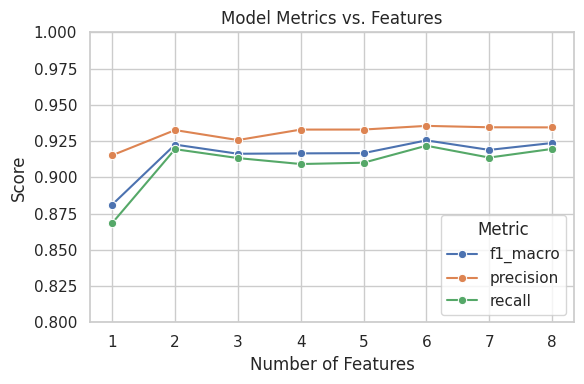

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Melt the DataFrame to have one row per metric
df_melted = df_ova_results.melt(id_vars='features',
                    value_vars=['f1_macro', 'precision', 'recall'],
                    var_name='Metric', value_name='Score')

# Plot
import seaborn as sns
sns.set(style='whitegrid')

plt.figure(figsize=(6, 4))
sns.lineplot(data=df_melted, x='features', y='Score', hue='Metric', marker='o')

plt.title('Model Metrics vs. Features')
plt.xlabel('Number of Features')
plt.ylabel('Score')
plt.ylim(0.8, 1)
plt.legend(title='Metric')
plt.tight_layout()
plt.show()

In [59]:
#PGExplainer 34 features
import time

nfeats = G.ndata['h']
efeats = G.edata['h']

edge_label = G.edata['label']
train_mask = G.edata['train_mask']

selected_features_per_class =selected_features_per_class_gnn
df_ova_results=[]

num=34
model = Model(num, 128, num, F.relu, 0.2).cuda()
opt = th.optim.Adam(model.parameters())

selected_features_per_class_r = {}
for key in selected_features_per_class:
  selected_features_per_class_r[key] = selected_features_per_class[key][:num]

  # train_losses = []
start_time = time.time()
for epoch in range(1,300):#200
 avg_loss = train_one_vs_all(model,G,nfeats, efeats,  edge_label, train_mask, opt, 5,selected_features_per_class_r)
 if epoch % 30 == 0 :
     print(avg_loss)
      # train_losses.append(avg_loss)

end_time = time.time()
train_time = end_time - start_time
print(f"Training time: {train_time:.2f} seconds")

# Training time: 645.13 seconds
start_time = time.time()
nfeats_test = G_test.ndata['feature']
efeats_test = G_test.edata['h']
# actual = G_test.edata['label']
predicted_classes = predict_one_vs_all(model,G_test, nfeats_test ,efeats_test,selected_features_per_class_r)

end_time = time.time()
test_time = end_time - start_time
print(f"Testing time: {test_time:.2f} seconds")


report = classification_report(actual.cpu(), predicted_classes.cpu(), output_dict=True)

/jobfs/145091752.gadi-pbs/ipykernel_4085186/147214995.py:17: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(outputs.squeeze()[train_mask], binary_labels[train_mask])
/scratch/kc01/na3038/my_env/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


0.17695595510303974
0.09197232350707055
0.0777049858123064
0.07095739990472794
0.07370073981583118
0.06815812159329653
0.07206585584208369
0.06510999193415046
0.06726250099018216
Training time: 525.81 seconds
Testing time: 0.42 seconds


AttributeError: 'numpy.ndarray' object has no attribute 'cpu'

In [60]:
test_pred= le.inverse_transform(predicted_classes.cpu())
report = classification_report(actual, test_pred, output_dict=True)


# Print a detailed report for each class
header = f"{'Class':<15}{'Precision':<10}{'Recall':<10}{'F2-score':<10}{'Accuracy':<10}{'Support':<10}"
print(header)
print("=" * len(header))

# Extract and print metrics for each class
for class_name, metrics in report.items():
    if class_name not in ['accuracy', 'macro avg', 'weighted avg']:
        accuracy = metrics['recall']  # For per-class, recall acts as accuracy
        print(f"{class_name:<15}{metrics['precision']:<10.4f}{metrics['recall']:<10.4f}{metrics['f1-score']:<10.4f}{accuracy:<10.4f}{int(metrics['support']):<10}")

# Print overall accuracy
print("\nOverall Accuracy:")
print(f"Accuracy: {report['accuracy']:.4f}")

# Print weighted averages
print("\nWeighted Averages:")
print(report['weighted avg'])

/scratch/kc01/na3038/my_env/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Class          Precision Recall    F2-score  Accuracy  Support   
Benign         0.9691    0.8348    0.8970    0.8348    81124     
DDoS           0.9941    0.9944    0.9942    0.9944    330036    
DoS            0.9862    0.9798    0.9830    0.9798    299908    
Reconnaissance 0.7246    0.9045    0.8046    0.9045    47218     
Theft          0.5125    0.9959    0.6767    0.9959    1466      

Overall Accuracy:
Accuracy: 0.9660

Weighted Averages:
{'precision': 0.9706564173116551, 'recall': 0.9660112773641926, 'f1-score': 0.9670286188269802, 'support': 759752.0}


## With E-PGExplainer

In [15]:
#PGExplainer 7 features
nfeats = G.ndata['h']
efeats = G.edata['h']

edge_label = G.edata['label']
train_mask = G.edata['train_mask']

selected_features_per_class =selected_features_per_class_pg
df_ova_results=[]

for num in range(39,10,-5):
  model = Model(num, 128, num, F.relu, 0.2).cuda()
  opt = th.optim.Adam(model.parameters())

  selected_features_per_class_r = {}
  for key in selected_features_per_class:
    selected_features_per_class_r[key] = selected_features_per_class[key][:num]

  # train_losses = []
  print(num, 'features')
  for epoch in range(1,200):#200
      avg_loss = train_one_vs_all(model,G,nfeats, efeats,  edge_label, train_mask, opt, 5,selected_features_per_class_r)
      # train_losses.append(avg_loss)

  nfeats_test = G_test.ndata['feature']
  efeats_test = G_test.edata['h']
  actual = G_test.edata['label']
  predicted_classes = predict_one_vs_all(model,G_test, nfeats_test ,efeats_test,selected_features_per_class_r)

  report = classification_report(actual.cpu(), predicted_classes.cpu(), output_dict=True)

  df_ova_results.append(
      {
        'features': num,
        # 'acc': report['accuracy'],
        'f1_macro': report['weighted avg']['f1-score'],
        'precision': report['weighted avg']['precision'],
        'recall': report['weighted avg']['recall']
    }
  )

  # del model
df_ova_results = pd.DataFrame(df_ova_results)
#todo append egraphsage / for all features ova


39 features


/jobfs/145091752.gadi-pbs/ipykernel_4085186/147214995.py:17: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(outputs.squeeze()[train_mask], binary_labels[train_mask])


34 features


/jobfs/145091752.gadi-pbs/ipykernel_4085186/147214995.py:17: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(outputs.squeeze()[train_mask], binary_labels[train_mask])
/scratch/kc01/na3038/my_env/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


29 features


/jobfs/145091752.gadi-pbs/ipykernel_4085186/147214995.py:17: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(outputs.squeeze()[train_mask], binary_labels[train_mask])
/scratch/kc01/na3038/my_env/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


24 features


/jobfs/145091752.gadi-pbs/ipykernel_4085186/147214995.py:17: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(outputs.squeeze()[train_mask], binary_labels[train_mask])
/scratch/kc01/na3038/my_env/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


19 features


/jobfs/145091752.gadi-pbs/ipykernel_4085186/147214995.py:17: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(outputs.squeeze()[train_mask], binary_labels[train_mask])
/scratch/kc01/na3038/my_env/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


14 features


/jobfs/145091752.gadi-pbs/ipykernel_4085186/147214995.py:17: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(outputs.squeeze()[train_mask], binary_labels[train_mask])
/scratch/kc01/na3038/my_env/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


In [52]:
df_ova_results

,features,f1_macro,precision,recall
0,39,0.725473,0.791505,0.705983
1,34,0.806478,0.814229,0.808440
2,29,0.681935,0.840040,0.590522
3,24,0.662808,0.786279,0.640036
4,19,0.686278,0.788496,0.658424
5,14,0.429342,0.770859,0.378914


In [16]:
df_ova_results = pd.read_csv('/scratch/kc01/na3038/TrainedModels/bot-v2/df_ova_results.csv')
df_ova_results

,features,f1_macro,precision,recall
0,39,0.725473,0.791505,0.705983
1,34,0.806478,0.814229,0.808440
2,29,0.681935,0.840040,0.590522
3,24,0.662808,0.786279,0.640036
4,19,0.686278,0.788496,0.658424
5,14,0.429342,0.770859,0.378914


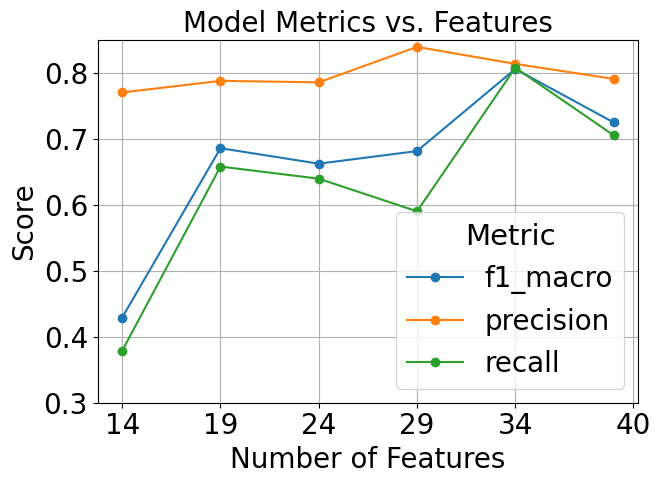

In [38]:
# import matplotlib.pyplot as plt
# import numpy as np
# import seaborn as sns

# # Melt the DataFrame to have one row per metric
# df_melted = df_ova_results.melt(id_vars='features',
#                     value_vars=['f1_macro', 'precision', 'recall'],
#                     var_name='Metric', value_name='Score')
# plt.figure(figsize=(6, 4))

# Plot each metric line separately
for metric in df_melted['Metric'].unique():
    subset = df_melted[df_melted['Metric'] == metric]

    x = subset['features'].to_numpy(dtype=float)
    y = subset['Score'].apply(
        lambda val: float(val[0]) if isinstance(val, (np.ndarray, list, tuple)) else float(val)
    ).to_numpy()

    plt.plot(x, y, marker='o', label=metric)

plt.title('Model Metrics vs. Features',fontsize=20)
plt.xlabel('Number of Features',fontsize=20)
plt.ylabel('Score',fontsize=20)
plt.ylim(0.30, 0.85)
plt.legend(title='Metric',fontsize=20, title_fontsize=21)
plt.grid(True)
plt.tight_layout()
plt.xticks([ 14, 19, 24, 29, 34, 40], fontsize=20)
plt.yticks(fontsize=20)
plt.savefig("/scratch/kc01/na3038/TrainedModels/bot-v2/plot.png", bbox_inches='tight', pad_inches=0.1) 
plt.show()
#this is the final result

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

# Melt the DataFrame to have one row per metric
df_melted = df_ova_results.melt(id_vars='features',
                    value_vars=['f1_macro', 'precision', 'recall'],
                    var_name='Metric', value_name='Score')

# Plot
# sns.set(style='whitegrid')

# plt.figure(figsize=(6, 4))
# sns.lineplot(data=df_melted, x='features', y='Score', hue='Metric', marker='o')

# plt.title('Model Metrics vs. Features')
# plt.xlabel('Number of Features')
# plt.ylabel('Score')
# plt.ylim(0.85, 0.95)
# plt.legend(title='Metric')
# plt.tight_layout()
# plt.show()

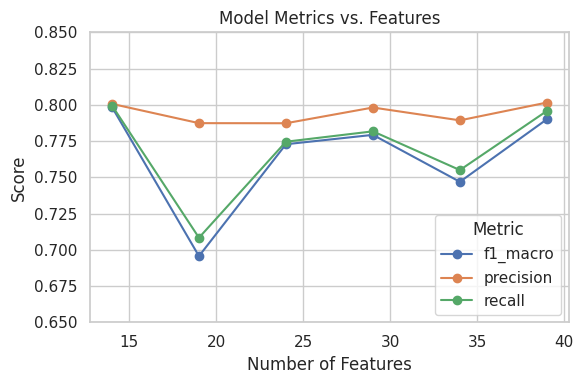

In [30]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(6, 4))

# Plot each metric line separately
for metric in df_melted['Metric'].unique():
    subset = df_melted[df_melted['Metric'] == metric]

    x = subset['features'].to_numpy(dtype=float)
    y = subset['Score'].apply(
        lambda val: float(val[0]) if isinstance(val, (np.ndarray, list, tuple)) else float(val)
    ).to_numpy()

    plt.plot(x, y, marker='o', label=metric)

plt.title('Model Metrics vs. Features')
plt.xlabel('Number of Features')
plt.ylabel('Score')
plt.ylim(0.65, 0.85)
plt.legend(title='Metric')
plt.grid(True)
plt.tight_layout()
plt.show()


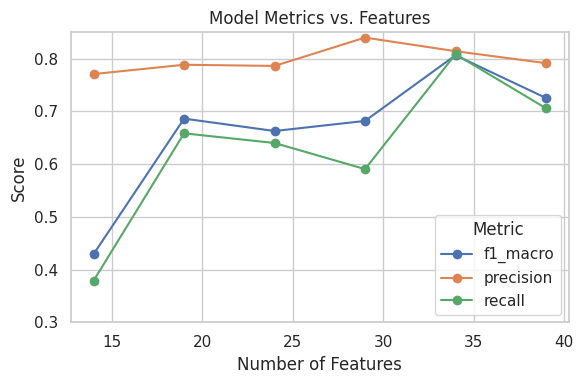

In [57]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(6, 4))

# Plot each metric line separately
for metric in df_melted['Metric'].unique():
    subset = df_melted[df_melted['Metric'] == metric]

    x = subset['features'].to_numpy(dtype=float)
    y = subset['Score'].apply(
        lambda val: float(val[0]) if isinstance(val, (np.ndarray, list, tuple)) else float(val)
    ).to_numpy()

    plt.plot(x, y, marker='o', label=metric)

plt.title('Model Metrics vs. Features')
plt.xlabel('Number of Features')
plt.ylabel('Score')
plt.ylim(0.30, 0.85)
plt.legend(title='Metric')
plt.grid(True)
plt.tight_layout()
plt.show()


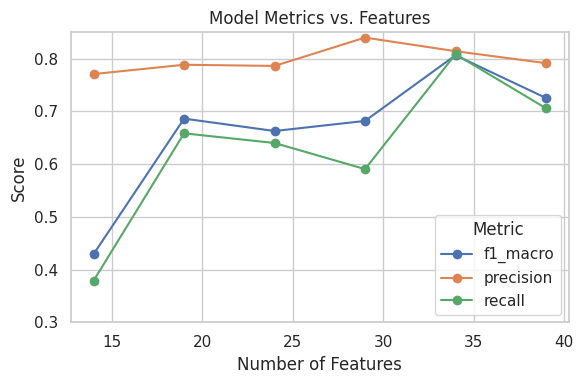

In [63]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(6, 4))

# Plot each metric line separately
for metric in df_melted['Metric'].unique():
    subset = df_melted[df_melted['Metric'] == metric]

    x = subset['features'].to_numpy(dtype=float)
    y = subset['Score'].apply(
        lambda val: float(val[0]) if isinstance(val, (np.ndarray, list, tuple)) else float(val)
    ).to_numpy()

    plt.plot(x, y, marker='o', label=metric)

plt.title('Model Metrics vs. Features')
plt.xlabel('Number of Features')
plt.ylabel('Score')
plt.ylim(0.30, 0.85)
plt.legend(title='Metric')
plt.grid(True)
plt.tight_layout()
plt.savefig("/scratch/kc01/na3038/TrainedModels/bot-v2/plot.png") 
plt.show()


In [39]:
#PGExplainer 34 features
import time

nfeats = G.ndata['h']
efeats = G.edata['h']

edge_label = G.edata['label']
train_mask = G.edata['train_mask']

selected_features_per_class =selected_features_per_class_pg
df_ova_results=[]

num=34
model = Model(num, 128, num, F.relu, 0.2).cuda()
opt = th.optim.Adam(model.parameters())

selected_features_per_class_r = {}
for key in selected_features_per_class:
  selected_features_per_class_r[key] = selected_features_per_class[key][:num]

  # train_losses = []
start_time = time.time()
for epoch in range(1,300):#200
 avg_loss = train_one_vs_all(model,G,nfeats, efeats,  edge_label, train_mask, opt, 5,selected_features_per_class_r)
 if epoch % 10 == 0 :
     print(avg_loss)
      # train_losses.append(avg_loss)

end_time = time.time()
train_time = end_time - start_time
print(f"Training time: {train_time:.2f} seconds")

# Training time: 645.13 seconds
start_time = time.time()
nfeats_test = G_test.ndata['feature']
efeats_test = G_test.edata['h']
# actual = G_test.edata['label']
predicted_classes = predict_one_vs_all(model,G_test, nfeats_test ,efeats_test,selected_features_per_class_r)

end_time = time.time()
test_time = end_time - start_time
print(f"Testing time: {test_time:.2f} seconds")


/jobfs/145091752.gadi-pbs/ipykernel_4085186/147214995.py:17: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(outputs.squeeze()[train_mask], binary_labels[train_mask])
/scratch/kc01/na3038/my_env/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


0.4235375761985779
0.2762003868818283
0.17915011793375016
0.13237861916422844
0.11023569107055664
0.10626811683177947
0.09448821172118187
0.08430309891700745
0.08333035111427307
0.08366690501570702
0.08482947014272213
0.07825685478746891
0.07647427432239055
0.07326878905296326
0.0734639398753643
0.07226641289889812
0.07139213010668755
0.07097902689129114
0.07104239128530025
0.06879632137715816
0.0680835198611021
0.06838764427229763
0.07184103457257152
0.0686930624768138
0.06719119139015675
0.07229397539049387
0.06684319898486138
0.06622646925970913
0.06658180225640535
Training time: 526.74 seconds
Testing time: 0.42 seconds


In [40]:
test_pred= le.inverse_transform(predicted_classes.cpu())
report = classification_report(le.inverse_transform(actual.cpu()), test_pred, output_dict=True)


# Print a detailed report for each class
header = f"{'Class':<15}{'Precision':<10}{'Recall':<10}{'F2-score':<10}{'Accuracy':<10}{'Support':<10}"
print(header)
print("=" * len(header))

# Extract and print metrics for each class
for class_name, metrics in report.items():
    if class_name not in ['accuracy', 'macro avg', 'weighted avg']:
        accuracy = metrics['recall']  # For per-class, recall acts as accuracy
        print(f"{class_name:<15}{metrics['precision']:<10.4f}{metrics['recall']:<10.4f}{metrics['f1-score']:<10.4f}{accuracy:<10.4f}{int(metrics['support']):<10}")

# Print overall accuracy
print("\nOverall Accuracy:")
print(f"Accuracy: {report['accuracy']:.4f}")

# Print weighted averages
print("\nWeighted Averages:")
print(report['weighted avg'])
# this is the final result

/scratch/kc01/na3038/my_env/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Class          Precision Recall    F2-score  Accuracy  Support   
Benign         0.9920    0.8455    0.9129    0.8455    81124     
DDoS           0.9939    0.9944    0.9942    0.9944    330036    
DoS            0.9862    0.9799    0.9830    0.9799    299908    
Reconnaissance 0.7242    0.9382    0.8175    0.9382    47218     
Theft          0.8512    0.7299    0.7859    0.7299    1466      

Overall Accuracy:
Accuracy: 0.9688

Weighted Averages:
{'precision': 0.9736423070484419, 'recall': 0.9687779696532552, 'f1-score': 0.9697170872714683, 'support': 759752.0}


In [ ]:
# 0.0066360002383589745 seconds
# Class          Precision Recall    F2-score  Accuracy  Support   
# =================================================================
# Benign         0.9948    0.8333    0.9069    0.8333    81124     
# DDoS           0.9941    0.9944    0.9942    0.9944    330036    
# DoS            0.9863    0.9793    0.9828    0.9793    299908    
# Reconnaissance 0.7156    0.9428    0.8137    0.9428    47218     
# Theft          0.8735    0.9939    0.9298    0.9939    1466      

# Overall Accuracy:
# Accuracy: 0.9680

# Weighted Averages:
# {'precision': 0.9735523428648185, 'recall': 0.968035622150386, 'f1-score': 0.9690525271553146, 'support': 759752.0}

In [61]:
test_pred= predicted_classes.cpu()

# Print a detailed report for each class
header = f"{'Class':<15}{'Precision':<10}{'Recall':<10}{'F2-score':<10}{'Accuracy':<10}{'Support':<10}"
print(header)
print("=" * len(header))

# Extract and print metrics for each class
for class_name, metrics in report.items():
    if class_name not in ['accuracy', 'macro avg', 'weighted avg']:
        accuracy = metrics['recall']  # For per-class, recall acts as accuracy
        print(f"{class_name:<15}{metrics['precision']:<10.4f}{metrics['recall']:<10.4f}{metrics['f1-score']:<10.4f}{accuracy:<10.4f}{int(metrics['support']):<10}")

# Print overall accuracy
print("\nOverall Accuracy:")
print(f"Accuracy: {report['accuracy']:.4f}")

# Print weighted averages
print("\nWeighted Averages:")
print(report['weighted avg'])

Class          Precision Recall    F2-score  Accuracy  Support   
0              0.8760    0.4197    0.5675    0.4197    81148     
1              0.8118    0.8308    0.8212    0.8308    330274    
2              0.8429    0.7630    0.8009    0.7630    299674    
3              0.7029    0.9180    0.7962    0.9180    47204     
4              0.0290    0.9972    0.0564    0.9972    1452      

Overall Accuracy:
Accuracy: 0.7659

Weighted Averages:
{'precision': 0.8226275820581276, 'recall': 0.765890711705925, 'f1-score': 0.7830850210150306, 'support': 759752.0}


In [ ]:
# Class          Precision Recall    F2-score  Accuracy  Support   
# =================================================================
# Benign         0.8537    0.5015    0.6318    0.5015    81148     
# DDoS           0.5591    0.9208    0.6958    0.9208    330274    
# DoS            0.8253    0.3832    0.5234    0.3832    299674    
# Reconnaissance 0.9612    0.5602    0.7079    0.5602    47204     
# Theft          0.9610    0.9835    0.9721    0.9835    1452      

# Overall Accuracy:
# Accuracy: 0.6417

# Weighted Averages:
# {'precision': 0.7213357138164559, 'recall': 0.6417172972233044, 'f1-score': 0.6222497187724996, 'support': 759752.0}

In [21]:
# test_pred= predicted_classes.cpu()

# Print a detailed report for each class
header = f"{'Class':<15}{'Precision':<10}{'Recall':<10}{'F2-score':<10}{'Accuracy':<10}{'Support':<10}"
print(header)
print("=" * len(header))

# Extract and print metrics for each class
for class_name, metrics in report.items():
    if class_name not in ['accuracy', 'macro avg', 'weighted avg']:
        accuracy = metrics['recall']  # For per-class, recall acts as accuracy
        print(f"{class_name:<15}{metrics['precision']:<10.4f}{metrics['recall']:<10.4f}{metrics['f1-score']:<10.4f}{accuracy:<10.4f}{int(metrics['support']):<10}")

# Print overall accuracy
print("\nOverall Accuracy:")
print(f"Accuracy: {report['accuracy']:.4f}")

# Print weighted averages
print("\nWeighted Averages:")
print(report['weighted avg'])

Class          Precision Recall    F2-score  Accuracy  Support   
Benign         0.8611    0.6465    0.7386    0.6465    81148     
DDoS           0.5724    0.9167    0.7048    0.9167    330274    
DoS            0.8203    0.3853    0.5243    0.3853    299674    
Reconnaissance 0.9568    0.5611    0.7073    0.5611    47204     
Theft          0.9637    0.9862    0.9748    0.9862    1452      

Overall Accuracy:
Accuracy: 0.6563

Weighted Averages:
{'precision': 0.7256453469182006, 'recall': 0.656253619602186, 'f1-score': 0.6378554775477804, 'support': 759752.0}


In [84]:
actual = le.inverse_transform(actual.cpu())
actual

array(['DDoS', 'DDoS', 'DDoS', ..., 'DDoS', 'Benign', 'DDoS'],
      dtype=object)

In [86]:
test_pred=le.inverse_transform(test_pred.cpu())

/scratch/kc01/na3038/my_env/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


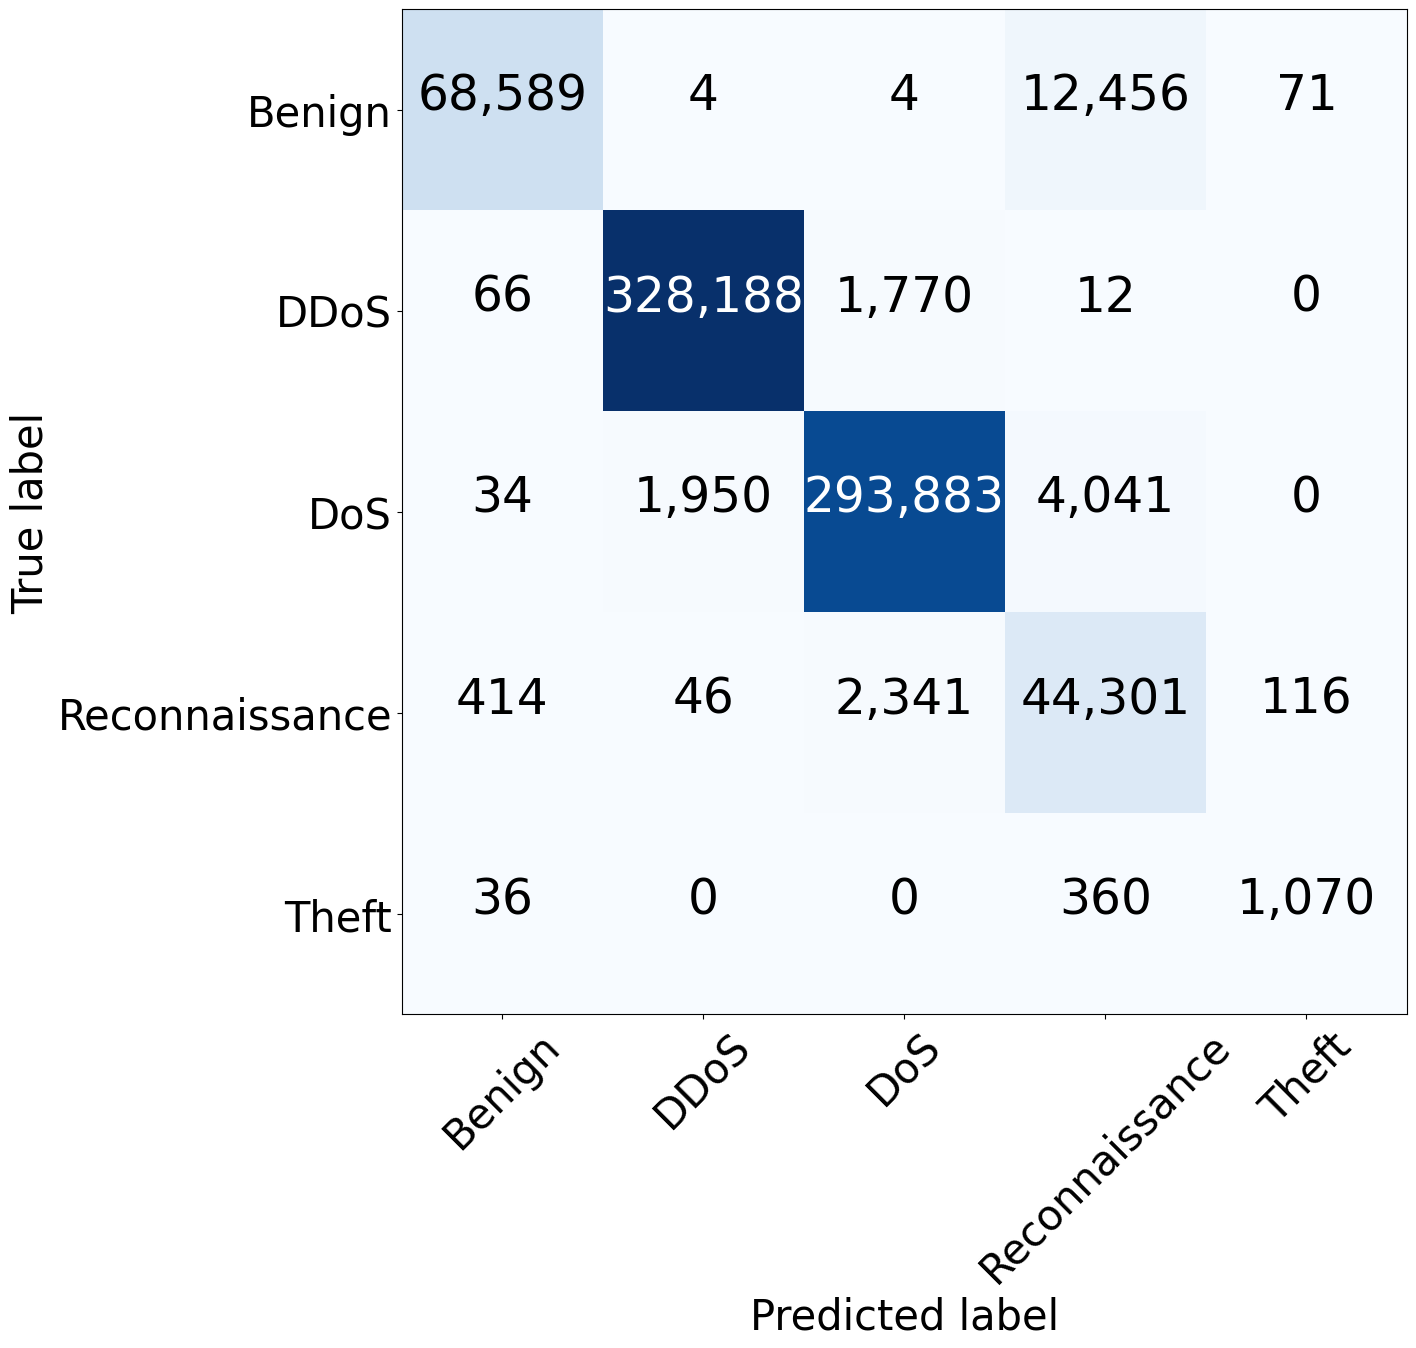

In [42]:
from sklearn.metrics import confusion_matrix
actual = le.inverse_transform(actual.cpu())
def plot_confusion_matrix(cm,
                          target_names,
                          # title='Confusion matrix',
                          cmap=None,
                          normalize=True,
                          fontsize=30,
                          text_fontsize=35):

    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(12, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    # plt.title(title,fontsize=fontsize + 2)
    # plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45,fontsize=fontsize)
        plt.yticks(tick_marks, target_names,fontsize=fontsize)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     fontsize=text_fontsize,
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     fontsize=text_fontsize,
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label',fontsize=fontsize)
    plt.xlabel('Predicted label',fontsize=fontsize)
    plt.subplots_adjust(left=0.15, bottom=0.15)
    plt.show()
plot_confusion_matrix(cm = confusion_matrix(actual, test_pred),
                      normalize    = False,
                      target_names = np.unique(actual),
                      # title        = "Confusion Matrix"
                      )

In [43]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm,
                          target_names,
                          cmap=None,
                          normalize=True,
                          fontsize=30,
                          text_fontsize=35):

    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(12, 12))
    # plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.imshow(cm, interpolation='nearest', cmap=cmap, aspect='auto')
    # plt.title(title,fontsize=fontsize + 2)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45,fontsize=fontsize)
        plt.yticks(tick_marks, target_names,fontsize=fontsize)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     fontsize=text_fontsize,
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     fontsize=text_fontsize,
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label',fontsize=fontsize)
    plt.xlabel('Predicted label',fontsize=fontsize)
    plt.subplots_adjust(left=0.15, bottom=0.15)
    plt.show()
plot_confusion_matrix(cm = confusion_matrix(actual.cpu(), test_pred),
                      normalize    = False,
                      target_names = np.unique(actual.cpu())
                      )

AttributeError: 'numpy.ndarray' object has no attribute 'cpu'

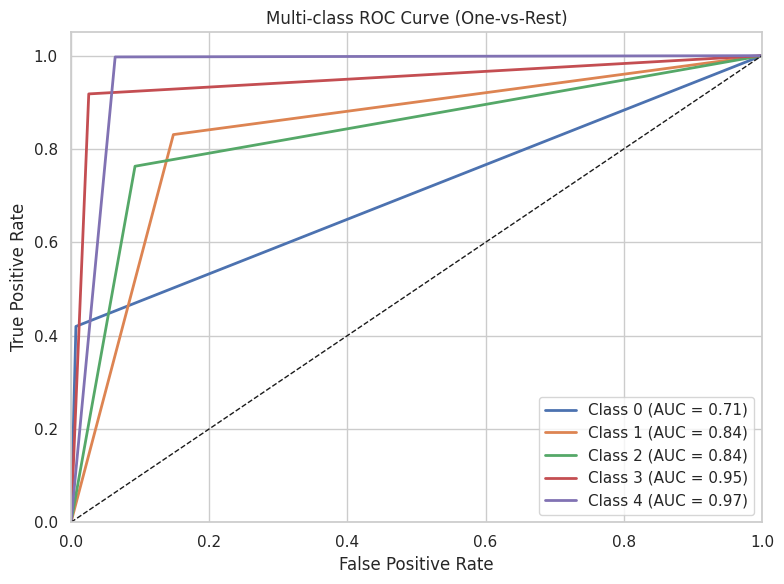

In [72]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Load example dataset
X = actual.cpu()
y = test_pred
classes = np.unique(actual.cpu())
n_classes = len(classes)

X_bin = label_binarize(X, classes=classes)  # shape: (n_samples, n_classes)
y_bin = label_binarize(y, classes=classes)  # shape: (n_samples, n_classes)

# 2. Plot ROC curve for each class
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(X_bin[:, i], y_bin[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"Class {classes[i]} (AUC = {roc_auc:.2f})")

# 3. Add plot decorations
plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve (One-vs-Rest)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
attk_class = 'DoS'
print('Class type explaining:', attk_class)
# attack_edge_to_explain = 0 #initialize
# attack_feature_array = {}
true_predicted_benign_edge_index = 13 #random.sample(true_positives[attk_class], 1) #true_predicted_edge_index
true_predicted_benign_edge_index

Class type explaining: DoS


13

In [ ]:
attack_edge_to_explain = list((G_test.edata['Edge_indx'] == true_predicted_benign_edge_index).nonzero(as_tuple=True)[0].cpu().detach().numpy())[0]
attack_edge_to_explain

2

In [ ]:
attck_efeat_indice, attck_efeat_sub_graph, attck_efeat_mask, attck_efeat_loss = explain_edge_features(model, attack_edge_to_explain, G_test, nfeats, efeats)
edge_feature_importance = (attck_efeat_mask.cpu().detach().tolist())

In [ ]:
feature_importance = {}
for i in range(8):
  feature_importance[cols_to_norm[i]]=edge_feature_importance[0][i]
sorted_items = sorted(feature_importance.items(), key=lambda x: x[1], reverse=True)
for key, value in sorted_items:
  print(f'{key}: {value}')

OUT_BYTES: 0.8523483276367188
L7_PROTO: 0.8491301536560059
IN_BYTES: 0.737597644329071
TCP_FLAGS: 0.6260159611701965
OUT_PKTS: -0.5418569445610046
PROTOCOL: -0.6635388731956482
IN_PKTS: -0.7264429926872253
FLOW_DURATION_MILLISECONDS: -0.8527140617370605


In [ ]:
attck_efeat_sub_graph

Graph(num_nodes=167208, num_edges=56525,
      ndata_schemes={'feature': Scheme(shape=(1, 8), dtype=torch.float32), '_ID': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'Edge_indx': Scheme(shape=(), dtype=torch.int64), 'label': Scheme(shape=(), dtype=torch.int64), 'h': Scheme(shape=(1, 8), dtype=torch.float32), '_ID': Scheme(shape=(), dtype=torch.int64)})

In [ ]:
true_positives['DoS']

[0,
 0,
 13,
 18,
 30,
 41,
 63,
 66,
 82,
 111,
 166,
 189,
 191,
 198,
 212,
 224,
 242,
 267,
 275,
 282,
 289,
 290,
 307,
 326,
 328,
 332,
 346,
 355,
 384,
 391,
 399,
 406,
 425,
 430,
 431,
 441,
 446,
 468,
 479,
 500,
 515,
 519,
 533,
 537,
 565,
 569,
 598,
 629,
 635,
 642,
 651,
 671,
 684,
 728,
 769,
 778,
 779,
 802,
 811,
 814,
 843,
 881,
 896,
 917,
 926,
 941,
 958,
 985,
 1008,
 1010,
 1019,
 1028,
 1029,
 1046,
 1050,
 1058,
 1067,
 1068,
 1098,
 1111,
 1127,
 1129,
 1151,
 1162,
 1174,
 1175,
 1183,
 1209,
 1227,
 1232,
 1238,
 1248,
 1254,
 1266,
 1288,
 1297,
 1305,
 1312,
 1358,
 1367,
 1376,
 1377,
 1397,
 1398,
 1446,
 1452,
 1470,
 1471,
 1478,
 1479,
 1480,
 1505,
 1509,
 1537,
 1557,
 1558,
 1570,
 1582,
 1591,
 1594,
 1595,
 1648,
 1657,
 1671,
 1693,
 1696,
 1722,
 1724,
 1747,
 1761,
 1766,
 1767,
 1778,
 1779,
 1787,
 1811,
 1835,
 1843,
 1846,
 1854,
 1864,
 1869,
 1870,
 1873,
 1883,
 1890,
 1899,
 1948,
 1955,
 1963,
 1977,
 1978,
 1979,
 1982,
 

In [ ]:
num_hops = 2
source_node = G_test.edges()[0][2].item()
sg, inverse_indices = khop_in_subgraph(G_test, source_node, num_hops)
sg

Graph(num_nodes=14060, num_edges=28118,
      ndata_schemes={'feature': Scheme(shape=(1, 8), dtype=torch.float32), '_ID': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'Edge_indx': Scheme(shape=(), dtype=torch.int64), 'label': Scheme(shape=(), dtype=torch.int64), 'h': Scheme(shape=(1, 8), dtype=torch.float32), '_ID': Scheme(shape=(), dtype=torch.int64)})

In [ ]:
G_test.edges()

(tensor([100782, 188616, 188616,  ...,  34183,  81931, 178447], device='cuda:0'),
 tensor([188616, 100782, 179456,  ..., 184316, 185576, 185990], device='cuda:0'))

In [ ]:
G_test.nodes()

tensor([     0,      1,      2,  ..., 188815, 188816, 188817], device='cuda:0')

In [ ]:
G_test.edges()[0][2].item()

188616

In [ ]:
G_test.edata['Edge_indx']

tensor([     0,      0,     13,  ..., 180027, 180028, 180029], device='cuda:0')

In [ ]:
X_test.iloc[13]

,47083
IPV4_SRC_ADDR,172.30.88.50:58690
IPV4_DST_ADDR,192.168.100.7:80
PROTOCOL,0.257369
L7_PROTO,-1.665568
IN_BYTES,-0.018551
OUT_BYTES,-0.00641
IN_PKTS,-0.029746
OUT_PKTS,-0.007791
TCP_FLAGS,-1.381534
FLOW_DURATION_MILLISECONDS,0.487975


In [ ]:
X_test[X_test['IPV4_SRC_ADDR']=='172.30.88.50:58690']

,IPV4_SRC_ADDR,IPV4_DST_ADDR,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,label,Edge_indx,h
47083,172.30.88.50:58690,192.168.100.7:80,0.257369,-1.665568,-0.018551,-0.00641,-0.029746,-0.007791,-1.381534,0.487975,1,13,"[-0.006409981374379563, -0.007791121753422729,..."


In [ ]:
X_test[X_test.index==188616]

,IPV4_SRC_ADDR,IPV4_DST_ADDR,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,label,Edge_indx,h


In [ ]:
X_test.index.shape

NameError: name 'X_test' is not defined

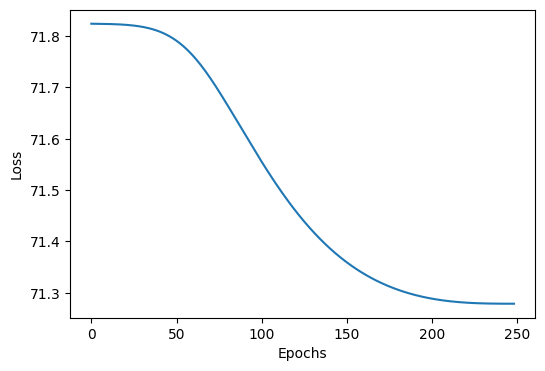

In [ ]:
attck_edge_indice, attck_sub_graph, attck_edge_mask, attck_loss = explain_edges(model, attack_edge_to_explain, G_test, nfeats, efeats,class_idx=1)

In [ ]:
attck_edge_mask.shape

torch.Size([28118])

In [ ]:
attck_sub_graph

Graph(num_nodes=14060, num_edges=28118,
      ndata_schemes={'feature': Scheme(shape=(1, 8), dtype=torch.float32), '_ID': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'Edge_indx': Scheme(shape=(), dtype=torch.int64), 'label': Scheme(shape=(), dtype=torch.int64), 'h': Scheme(shape=(1, 8), dtype=torch.float32), '_ID': Scheme(shape=(), dtype=torch.int64)})

In [ ]:
attck_edge_mask[attck_edge_mask > 0.8].unique()

tensor([0.8846, 0.8850, 0.8851,  ..., 0.8866, 0.8866, 0.8866], device='cuda:0')

In [ ]:
# edge_mask_intrusion_round = th.round(attck_edge_mask)
# unwanted_1 = list((edge_mask_intrusion_round == 0).nonzero(as_tuple=True)[0].cpu().detach().numpy())
unwanted_1 = list((attck_edge_mask < 0.8866).nonzero(as_tuple=True)[0].cpu().detach().numpy())
if attck_edge_indice in unwanted_1:
    unwanted_1.remove(attck_edge_indice)

In [ ]:
len(unwanted_1)

27284

In [ ]:
g_intrusion = dgl.remove_edges(attck_sub_graph, unwanted_1)
isolated_nodes = ((g_intrusion.in_degrees() == 0) & (g_intrusion.out_degrees() == 0)).nonzero().squeeze(1)
g_intrusion.remove_nodes(isolated_nodes)

In [ ]:
g_intrusion

Graph(num_nodes=822, num_edges=834,
      ndata_schemes={'feature': Scheme(shape=(1, 8), dtype=torch.float32), '_ID': Scheme(shape=(), dtype=torch.int64)}
      edata_schemes={'Edge_indx': Scheme(shape=(), dtype=torch.int64), 'label': Scheme(shape=(), dtype=torch.int64), 'h': Scheme(shape=(1, 8), dtype=torch.float32), '_ID': Scheme(shape=(), dtype=torch.int64)})

In [ ]:
file_path = "/content/drive/MyDrive/Colab Notebooks/Datasets/TrainedModels/g_intrusion.dgl"
save_graphs(file_path, g_intrusion)

# Load the graph
loaded_graphs, _ = load_graphs(file_path)
g_intrusion = loaded_graphs[0]

# Verify the loaded graph (optional)
print(g_intrusion)

Graph(num_nodes=822, num_edges=834,
      ndata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64), 'feature': Scheme(shape=(1, 8), dtype=torch.float32)}
      edata_schemes={'_ID': Scheme(shape=(), dtype=torch.int64), 'h': Scheme(shape=(1, 8), dtype=torch.float32), 'label': Scheme(shape=(), dtype=torch.int64), 'Edge_indx': Scheme(shape=(), dtype=torch.int64)})


In [ ]:
nx_graph_intrusion = dgl.to_networkx(g_intrusion.cpu(), edge_attrs = g_intrusion.cpu().edata)
nx_graph_intrusion

In [ ]:
nx_graph_intrusion_Label = nx.get_edge_attributes(nx_graph_intrusion, "label")
keyss = list(nx_graph_intrusion_Label.keys())
valuess = list(nx_graph_intrusion_Label.values())
edge_labelss = dict()
for indx, x in enumerate(keyss):
    edge_labelss[tuple([x[0], x[1]])] = valuess[indx].item()

In [ ]:
edge_labelss

{(0, 821): 1,
 (2, 821): 1,
 (3, 821): 1,
 (4, 821): 1,
 (6, 821): 1,
 (7, 821): 1,
 (10, 821): 1,
 (12, 821): 1,
 (16, 821): 1,
 (17, 821): 1,
 (18, 821): 1,
 (19, 821): 1,
 (21, 821): 1,
 (22, 821): 1,
 (25, 821): 1,
 (26, 821): 1,
 (27, 821): 1,
 (35, 821): 1,
 (37, 821): 1,
 (38, 821): 1,
 (42, 821): 1,
 (44, 821): 1,
 (45, 821): 1,
 (47, 821): 1,
 (49, 821): 1,
 (50, 821): 1,
 (51, 821): 1,
 (54, 821): 1,
 (55, 821): 1,
 (57, 821): 1,
 (58, 821): 1,
 (59, 821): 1,
 (60, 821): 1,
 (62, 821): 1,
 (65, 821): 1,
 (67, 821): 1,
 (68, 821): 1,
 (77, 821): 1,
 (79, 821): 1,
 (80, 821): 1,
 (82, 821): 1,
 (83, 821): 1,
 (85, 821): 1,
 (87, 821): 1,
 (91, 821): 1,
 (94, 821): 1,
 (98, 821): 1,
 (99, 821): 1,
 (100, 821): 1,
 (102, 821): 1,
 (104, 821): 1,
 (105, 821): 1,
 (106, 821): 1,
 (107, 821): 1,
 (115, 821): 1,
 (121, 821): 1,
 (122, 821): 1,
 (123, 821): 1,
 (124, 821): 1,
 (129, 821): 1,
 (133, 821): 1,
 (135, 821): 1,
 (136, 821): 1,
 (137, 821): 1,
 (139, 821): 1,
 (140, 821): 1

In [ ]:
# The explained edge
nx_graph_intrusion_Edge_indx = nx.get_edge_attributes(nx_graph_intrusion, "Edge_indx")
keyss_Edge_indx = list(nx_graph_intrusion_Edge_indx.keys())
valuess_Edge_indx = list(nx_graph_intrusion_Edge_indx.values())
orange_edge = 0
for indx, x in enumerate(valuess_Edge_indx):
    if x.item() == attck_sub_graph.edata["Edge_indx"][attck_edge_indice].item():
        orange_edge = tuple([keyss_Edge_indx[indx][0], keyss_Edge_indx[indx][1]])
orange_edge

(816, 821)

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

plt.figure(figsize=[200,200])
plt.title("Explanability of an intrusion edge")
pos = nx.circular_layout(nx_graph_intrusion)

nx.draw_networkx_edges(nx_graph_intrusion, pos, width = 2, alpha = 0.5, edge_color = "blue")
nx.draw_networkx_nodes(nx_graph_intrusion, pos)
# nx.draw_networkx_labels(nx_graph_intrusion, pos)

nx.draw_networkx_edges(
    nx_graph_intrusion,
    pos,
    edgelist = [orange_edge],
    width = 2,
    alpha = 0.9,
    edge_color = "red",
)

nx.draw_networkx_edge_labels(nx_graph_intrusion, pos, edge_labels = edge_labelss) #

{(0, 821): Text(0.9999853977173365, -0.0038217437738610194, '1'),
 (2, 821): Text(0.9999269852330959, 0.0038212711629721507, '1'),
 (3, 821): Text(0.9998539386196477, 0.007642720248757007, '1'),
 (4, 821): Text(0.9997517172314798, 0.011463173665838156, '1'),
 (6, 821): Text(0.999459658164723, 0.019101115637356836, '1'),
 (7, 821): Text(0.9992698451691653, 0.022918401954895806, '1'),
 (10, 821): Text(0.9985254212288308, 0.0343594168580208, '1'),
 (12, 821): Text(0.9978834817612929, 0.041976817966890456, '1'),
 (16, 821): Text(0.996250706065509, 0.05717615072632154, '1'),
 (17, 821): Text(0.9957699469005079, 0.06096746094409444, '1'),
 (18, 821): Text(0.9952602615205075, 0.06475483630420409, '1'),
 (19, 821): Text(0.994721571344714, 0.06853921262622231, '1'),
 (21, 821): Text(0.9935575860053456, 0.07609368497975888, '1'),
 (22, 821): Text(0.9929323158743015, 0.0798639019985794, '1'),
 (25, 821): Text(0.9908838318613205, 0.09114539157141777, '1'),
 (26, 821): Text(0.9901436274171904, 0.09

## Notes

In [28]:
#PGExplainer 7 features
import time

nfeats = G.ndata['h']
efeats = G.edata['h']

edge_label = G.edata['label']
train_mask = G.edata['train_mask']

selected_features_per_class =selected_features_per_class_pg
df_ova_results=[]

num=34
model = Model(num, 128, num, F.relu, 0.2).cuda()
opt = th.optim.Adam(model.parameters())

selected_features_per_class_r = {}
for key in selected_features_per_class:
  selected_features_per_class_r[key] = selected_features_per_class[key][:num]

  # train_losses = []
start_time = time.time()
for epoch in range(1,200):#200
 avg_loss = train_one_vs_all(model,G,nfeats, efeats,  edge_label, train_mask, opt, 5,selected_features_per_class_r)
      # train_losses.append(avg_loss)

end_time = time.time()
train_time = end_time - start_time
print(f"Training time: {train_time:.2f} seconds")

# Training time: 645.13 seconds
start_time = time.time()
nfeats_test = G_test.ndata['feature']
efeats_test = G_test.edata['h']
# actual = G_test.edata['label']
predicted_classes = predict_one_vs_all(model,G_test, nfeats_test ,efeats_test,selected_features_per_class_r)

end_time = time.time()
test_time = end_time - start_time
print(f"Testing time: {test_time:.2f} seconds")




/jobfs/144799522.gadi-pbs/ipykernel_3248451/147214995.py:17: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = criterion(outputs.squeeze()[train_mask], binary_labels[train_mask])
/scratch/kc01/na3038/my_env/lib/python3.9/site-packages/torch/autograd/graph.py:744: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Training time: 319.37 seconds
Testing time: 0.47 seconds


In [29]:
test_pred= le.inverse_transform(predicted_classes.cpu())
report = classification_report(actual,test_pred, output_dict=True)

# Print a detailed report for each class
header = f"{'Class':<15}{'Precision':<10}{'Recall':<10}{'F2-score':<10}{'Accuracy':<10}{'Support':<10}"
print(header)
print("=" * len(header))

# Extract and print metrics for each class
for class_name, metrics in report.items():
    if class_name not in ['accuracy', 'macro avg', 'weighted avg']:
        accuracy = metrics['recall']  # For per-class, recall acts as accuracy
        print(f"{class_name:<15}{metrics['precision']:<10.4f}{metrics['recall']:<10.4f}{metrics['f1-score']:<10.4f}{accuracy:<10.4f}{int(metrics['support']):<10}")

# Print overall accuracy
print("\nOverall Accuracy:")
print(f"Accuracy: {report['accuracy']:.4f}")

# Print weighted averages
print("\nWeighted Averages:")
print(report['weighted avg'])

/scratch/kc01/na3038/my_env/lib/python3.9/site-packages/sklearn/preprocessing/_label.py:153: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Class          Precision Recall    F2-score  Accuracy  Support   
Benign         0.8522    0.3751    0.5209    0.3751    81148     
DDoS           0.8294    0.6536    0.7311    0.6536    330274    
DoS            0.8638    0.4733    0.6115    0.4733    299674    
Reconnaissance 0.7151    0.8778    0.7882    0.8778    47204     
Theft          0.0060    0.9931    0.0119    0.9931    1452      

Overall Accuracy:
Accuracy: 0.5673

Weighted Averages:
{'precision': 0.8367503076849961, 'recall': 0.5673101222504185, 'f1-score': 0.663645911456317, 'support': 759752.0}
